# Proyek Machine Learning Terapan: Movielens 100k
Nama: Filza Rahma Muflihah

Email: filzarahmamuflihah@gmail.com

ID Dicoding: filza_rahma_muflihah

## Tentang Dataset MovieLens

Dataset MovieLens adalah kumpulan peringkat film yang dibuat oleh Proyek Penelitian GroupLens di Universitas Minnesota. Ini berisi peringkat pada skala 0.5-5.0 yang diberikan oleh pengguna untuk film.

**File Dataset**:
- `movies.csv`: Berisi informasi film termasuk judul dan genre
  - Kolom: movieId, judul, genre (dipisahkan dengan tanda petik)
- `ratings.csv`: Berisi peringkat pengguna untuk film
  - Kolom: userId, movieId, peringkat (skala 0.5-5.0), cap waktu

Ini adalah Dataset Terbaru Kecil MovieLens yang berisi sekitar 100.000 peringkat yang diterapkan pada 9.000 film oleh 600 pengguna. Dataset ini sering digunakan untuk mengembangkan dan menguji algoritme rekomendasi.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-07 11:33:48.176127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746617628.450218      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746617628.522428      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/movie-lens-small-latest-dataset/movies.csv
/kaggle/input/movie-lens-small-latest-dataset/ratings.csv
/kaggle/input/movie-lens-small-latest-dataset/README.txt
/kaggle/input/movie-lens-small-latest-dataset/tags.csv
/kaggle/input/movie-lens-small-latest-dataset/links.csv


# 1. Dataset Loading

Pada bagian ini, kita akan memuat dataset MovieLens yang berisi informasi film dan peringkat pengguna. Dataset MovieLens terdiri dari beberapa file, namun pada proyek ini kita akan fokus pada dua file utama: file film (movies.csv) dan file peringkat (ratings.csv).

Langkah pertama yang kita lakukan adalah mendefinisikan path atau jalur menuju file dataset. 

In [67]:
movie_path = '/kaggle/input/movie-lens-small-latest-dataset/movies.csv'
rating_path = '/kaggle/input/movie-lens-small-latest-dataset/ratings.csv'

## Memuat Data Film

Selanjutnya kita akan memuat data film (movies.csv) menggunakan fungsi `read_csv()` dari library pandas. File movies.csv berisi informasi tentang film-film yang tersedia dalam dataset, termasuk ID film, judul film, dan genre film. Setelah memuat data, kita akan menampilkan 5 baris pertama untuk melihat strukturnya.

In [68]:
# Memuat data film
movies_df = pd.read_csv(movie_path)
print(f"Number of movies: {len(movies_df)}")
movies_df.head()

Number of movies: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Data film yang telah dimuat memiliki struktur sebagai berikut:

* `movieId`: ID unik untuk setiap film dalam database
* `title`: Judul film, biasanya disertai dengan tahun rilis dalam tanda kurung
* `genres`: Genre film yang dipisahkan dengan karakter '|' (pipe), seperti 'Adventure|Animation|Children'

## Memuat Data Rating

Selanjutnya kita akan memuat data rating (ratings.csv) yang berisi informasi tentang peringkat yang diberikan pengguna pada film-film tertentu. Data ini mencakup ID pengguna, ID film, nilai rating, dan timestamp kapan rating diberikan.

In [69]:
# Memuat data rating
ratings_df = pd.read_csv(rating_path)
print(f"Number of ratings: {len(ratings_df)}")
ratings_df.head()

Number of ratings: 100836


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Data rating yang telah dimuat memiliki struktur sebagai berikut:

* `userId`: ID unik untuk setiap pengguna dalam database
* `movieId`: ID film yang diberi rating oleh pengguna
* `rating`: Nilai rating yang diberikan pengguna (skala 0.5 hingga 5.0 dengan interval 0.5)
* `timestamp`: Waktu ketika rating diberikan (dalam format UNIX timestamp)

Dataset rating berhubungan dengan dataset film melalui movieId.

Data rating ini akan menjadi dasar untuk pembangunan sistem rekomendasi, khususnya untuk model collaborative filtering yang memanfaatkan interaksi antara pengguna dan film.

# 2. Data Understanding

Pada bagian ini, kita akan melakukan eksplorasi awal untuk memahami struktur dan karakteristik data yang telah dimuat. Proses ini penting untuk mengenali pola, potensi masalah, dan gambaran umum dataset sebelum melakukan preprocessing lebih lanjut.

## 2.1 Eksplorasi Informasi Dataset Film

Langkah pertama dalam memahami data adalah memeriksa struktur dan karakteristik dataset film yang kita miliki. Kita akan memeriksa informasi umum dataset, duplikasi data, dan nilai yang hilang (missing value).

In [70]:
# Eksplorasi data dasar untuk film
print("Informasi dataset film:")
print(movies_df.info(), '\n')

# Memeriksa apakah ada data duplikat dalam dataset film
print("Banyaknya data duplikat pada dataset film:")
print(movies_df.duplicated().sum(),'\n')

# Memeriksa nilai yang hilang (missing value) pada dataset rating
print("Banyaknya missing value pada dataset film:")
print(movies_df.isna().sum())

Informasi dataset film:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None 

Banyaknya data duplikat pada dataset film:
0 

Banyaknya missing value pada dataset film:
movieId    0
title      0
genres     0
dtype: int64


Berikut adalah kesimpulan yang dapat diambil pada ekplorasi dasar dataset film:

1. **Struktur Dataset Film**:
    - Dataset film memiliki informasi lengkap tentang jumlah kolom, tipe data, dan jumlah nilai non-null di setiap kolom. Hal ini menunjukkan bahwa dataset sudah memiliki struktur yang baik untuk analisis lebih lanjut.

2. **Data Duplikat**:
    - Tidak ditemukan data duplikat dalam dataset film. Ini berarti dataset tidak memerlukan langkah tambahan untuk menghapus duplikasi.

3. **Nilai yang Hilang (Missing Values)**:
    - Tidak ada nilai yang hilang di dataset film. Ini menunjukkan bahwa dataset sudah bersih dan tidak memerlukan penanganan khusus terkait missing values.

## 2.2 Eksplorasi Informasi Dataset Rating

Selanjutnya, kita akan melakukan hal yang sama pada dataset rating. Kita perlu memahami struktur data rating sebelum menggunakannya untuk membuat sistem rekomendasi.

In [71]:
# Eksplorasi data dasar untuk rating
print("Informasi dataset rating:")
print(ratings_df.info(), '\n')

# Memeriksa apakah ada data duplikat dalam dataset rating
print("Banyaknya data duplikat pada dataset rating:")
print(ratings_df.duplicated().sum(),'\n')

# Memeriksa nilai yang hilang (missing value) pada dataset rating
print("Banyaknya missing value pada dataset rating:")
print(ratings_df.isna().sum())

Informasi dataset rating:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None 

Banyaknya data duplikat pada dataset rating:
0 

Banyaknya missing value pada dataset rating:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Berikut adalah kesimpulan yang dapat diambil pada ekplorasi dasar dataset rating:
1. **Struktur Dataset Rating**:
    - Dataset rating memiliki informasi lengkap tentang jumlah kolom, tipe data, dan jumlah nilai non-null di setiap kolom. Hal ini menunjukkan bahwa dataset sudah memiliki struktur yang baik untuk analisis lebih lanjut.

2. **Data Duplikat**:
    - Tidak ditemukan data duplikat dalam dataset rating. Ini berarti dataset tidak memerlukan langkah tambahan untuk menghapus duplikasi.

3. **Nilai yang Hilang (Missing Values)**:
    - Tidak ada nilai yang hilang di dataset rating. Ini menunjukkan bahwa dataset sudah bersih dan tidak memerlukan penanganan khusus terkait missing values.

# 3. Data Preparation

Pada bagian ini, kita akan melakukan serangkaian langkah untuk mempersiapkan data sebelum masuk ke tahap analisis mendalam dan pemodelan. Tahap preprocessing data sangat penting dalam proyek machine learning untuk memastikan data bersih, terstruktur, dan siap digunakan.

## 3.1 Penggabungan Data

Untuk analisis yang lebih komprehensif, kita perlu menggabungkan informasi dari dataset film dengan dataset rating. Proses penggabungan ini memungkinkan kita menganalisis hubungan antara karakteristik film (seperti genre dan tahun rilis) dengan penilaian yang diberikan pengguna.

In [72]:
# Menggabungkan dataset film dan rating berdasarkan movieId
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
print(f"Jumlah baris setelah penggabungan: {len(merged_df)}")

# Melihat hasil penggabungan
merged_df.head()

Jumlah baris setelah penggabungan: 100836


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Penggabungan data dilakukan dengan metode `left join` menggunakan kolom `movieId` sebagai kunci penghubung. Ini memastikan bahwa semua data rating tetap dipertahankan, dan informasi film ditambahkan pada setiap rating yang sesuai. Hasil penggabungan ini akan memudahkan analisis preferensi pengguna terhadap film berdasarkan karakteristiknya pada tahap Exploratory Data Analysis.

## 3.2 Feature Engineering

Feature engineering adalah proses menciptakan fitur baru dari data yang ada untuk meningkatkan performa model. Pada bagian ini, kita akan menambahkan beberapa fitur penting yang dapat memperkaya analisis dataset.

In [129]:
# Feature engineering
# Langkah 1: Ekstrak tahun dari judul film
def extract_year(title):
    # Memastikan tidak ada spasi di akhir judul
    title = title.rstrip()
    # Mencari pola tahun dalam format (YYYY) menggunakan ekspresi reguler
    pattern = r'\((\d{4})\)'
    match = re.search(pattern, title)
    if match:
        return int(match.group(1))  # Mengkonversi string tahun ke integer
    else:
        return None  # Jika tidak ditemukan tahun

# Menerapkan fungsi ekstraksi tahun ke kolom 'title'
merged_df['year'] = merged_df['title'].apply(extract_year)
movies_df['year'] = movies_df['title'].apply(extract_year)
movie_with_year = merged_df.groupby('movieId')['year'].agg('count').reset_index()
print(f"Tahun diekstraksi untuk {movie_with_year['year'].count()} film dari {len(movies_df)}")

# Langkah 2: Menambahkan informasi rating rata-rata ke dataframe film
# Mengelompokkan rating berdasarkan movieId dan menghitung rata-rata serta jumlah rating
movie_ratings = merged_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
# Menggabungkan informasi rating dengan dataframe film berdasarkan movieId
movies_with_ratings = pd.merge(merged_df, movie_ratings, on='movieId', how='left')

# Langkah 3: Menghitung jumlah genre untuk setiap film
# Genre dipisahkan oleh karakter '|', sehingga kita hitung jumlah genre dengan memisahkan string
merged_df['genre_count'] = merged_df['genres'].apply(lambda x: len(x.split('|')))

# Langkah 4: Membuat daftar dari semua genre yang ada dalam dataset
# Ini berguna untuk analisis distribusi genre
all_genres = []
for genres in merged_df['genres']:
    # Memisahkan string genre dan menambahkannya ke daftar all_genres
    all_genres.extend(genres.split('|'))
# Menghitung frekuensi kemunculan setiap genre
genres_count = Counter(all_genres)

print(f"Ditemukan {len(genres_count)} genre unik")

Tahun diekstraksi untuk 9724 film dari 9742
Ditemukan 20 genre unik


Pada langkah feature engineering di atas, kita telah melakukan beberapa transformasi data penting:

1. **Ekstraksi Tahun** - Mengekstrak tahun rilis film dari judul menggunakan ekspresi reguler untuk analisis tren dan pola berdasarkan waktu.

2. **Penambahan Rating Rata-rata** - Menghitung rating rata-rata dan jumlah rating untuk setiap film, lalu menggabungkannya dengan dataset film. Ini membantu dalam mengidentifikasi film populer dan yang disukai pengguna.

3. **Perhitungan Jumlah Genre** - Menambahkan fitur yang menunjukkan berapa banyak genre yang dimiliki oleh setiap film. Film dengan genre lebih banyak mungkin memiliki karakteristik berbeda dengan film dengan genre tunggal.

4. **Analisis Genre** - Membuat daftar semua genre yang ada dalam dataset dan menghitung frekuensinya untuk distribusi genre dalam koleksi film.

Fitur-fitur baru ini akan memperkaya dataset kita dan memungkinkan analisis yang lebih mendalam pada tahap berikutnya.

## 3.3 Ekstraksi Fitur dengan TF-IDF

Untuk sistem rekomendasi berbasis konten, kita perlu mengekstrak fitur dari data genre film. Teknik Term Frequency-Inverse Document Frequency (TF-IDF) akan digunakan untuk mengubah data tekstual genre menjadi representasi numerik yang dapat digunakan untuk menghitung kesamaan antar film.

In [81]:
# TF-IDF pada data genre film
tfidf = TfidfVectorizer(token_pattern=r'[^|]+') # karena genre dipisahkan dengan karakter "|"
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Melihat dimensi matriks TF-IDF
print(f"Dimensi matriks TF-IDF: {tfidf_matrix.shape}")

Dimensi matriks TF-IDF: (9742, 20)


Pada langkah di atas, kita telah melakukan proses ekstraksi fitur penting untuk model rekomendasi berbasis konten:

1. **Vektorisasi TF-IDF**: Kita menggunakan TF-IDF Vectorizer untuk mengubah data genre menjadi representasi numerik. TF-IDF mengukur pentingnya suatu kata (genre) dalam dokumen relatif terhadap koleksi dokumen secara keseluruhan.

2. **Konfigurasi Pola Token**: Pola token khusus (`token_pattern=r'[^|]+'`) dikonfigurasi karena genre dalam dataset dipisahkan dengan karakter '|'. Ini memungkinkan TF-IDF mengenali setiap genre sebagai token terpisah.

Hasil matrix TF-IDF ini akan digunakan pada tahap pembuatan model untuk Content-Based Filtering.

# 4. Exploratory Data Analysis (EDA)

Pada bagian ini, kita akan melakukan eksplorasi dan visualisasi data untuk memahami pola, hubungan, dan wawasan yang akan membantu dalam pengembangan model rekomendasi film. Proses EDA sangat penting untuk mendapatkan pemahaman mendalam tentang karakteristik dataset sebelum membangun model.

## 4.1 Analisis Statistik

Pertama-tama, kita akan memeriksa statistik deskriptif dari dataset film dan rating untuk memahami distribusi dan karakteristik umum data. Analisis statistik ini memberikan gambaran awal tentang rentang nilai, rata-rata, dan sebaran data yang kita miliki.

In [82]:
# Statistik deskriptif untuk dataset film
print("Statistik deskriptif untuk dataset film:")
movies_df.describe()

Statistik deskriptif untuk dataset film:


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


Berdasarkan hasil statistik deskriptif yang ditampilkan, terdapat beberapa informasi penting yang dapat diambil mengenai kolom-kolom numerik dalam dataset film, yaitu
**movieId**
- Nilai ID film berkisar antara 1 hingga 193609 dengan rata-rata 42.200.
- Sebagian besar ID film berada dalam rentang 3.248 hingga 76.232 (kuartil ke-1 hingga kuartil ke-3).


In [83]:
# Statistik deskriptif untuk dataset rating
print("Statistik deskriptif untuk dataset rating:")
ratings_df.describe()

Statistik deskriptif untuk dataset rating:


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Berdasarkan hasil statistik deskriptif yang ditampilkan, terdapat beberapa informasi penting yang dapat diambil mengenai kolom-kolom numerik dalam dataset rating:

1. **userId**
    - ID pengguna berkisar antara 1 hingga 610, dengan rata-rata user ID berada di angka 326.
    - Sebagian besar pengguna memiliki ID dalam rentang 177 hingga 477.

2. **movieId**
    - ID film yang diberi rating oleh pengguna berkisar antara 1 hingga 193609, dengan rata-rata 19.435.
    - Sebagian besar film yang diberi rating berada dalam ID 1.199 hingga 8.122, menunjukkan bahwa film-film dengan ID lebih kecil cenderung lebih populer atau lebih banyak di-rating.

3. **rating**
    - Rating yang diberikan pengguna berkisar antara 0.5 hingga 5, dengan rata-rata rating sebesar 3.50.
    - Sebagian besar rating berada pada rentang 3.0 hingga 4.0, menunjukkan adanya kecenderungan pengguna memberikan rating yang cukup positif terhadap film yang mereka tonton.

4. **timestamp**
    - Nilai timestamp berkisar antara 828.124.600 hingga 1.537.799.579 (dalam format Unix time), dengan rata-rata sekitar 1.205.946.000.
    - Sebagian besar aktivitas rating dilakukan antara timestamp 1.019.124.000 hingga 1.435.994.000, yang jika dikonversi, menunjukkan aktivitas pengguna yang dominan terjadi dalam kurun waktu antara tahun 2002 hingga 2015.

In [84]:
# Statistik deskriptif untuk dataset gabungan
print("Statistik deskriptif untuk dataset gabungan:")
merged_df.describe()

Statistik deskriptif untuk dataset gabungan:


,userId,movieId,rating,timestamp,year,genre_count
count,100836.000000,100836.000000,100836.000000,1.008360e+05,100818.000000,100836.000000
mean,326.127564,19435.295718,3.501557,1.205946e+09,1994.444990,2.722044
std,182.618491,35530.987199,1.042529,2.162610e+08,14.361424,1.193275
min,1.000000,1.000000,0.500000,8.281246e+08,1902.000000,1.000000
25%,177.000000,1199.000000,3.000000,1.019124e+09,1990.000000,2.000000
50%,325.000000,2991.000000,3.500000,1.186087e+09,1997.000000,3.000000
75%,477.000000,8122.000000,4.000000,1.435994e+09,2003.000000,3.000000
max,610.000000,193609.000000,5.000000,1.537799e+09,2018.000000,10.000000


Berdasarkan hasil statistik deskriptif yang ditampilkan, terdapat beberapa informasi penting yang dapat diambil mengenai kolom-kolom numerik dalam dataset gabungan:

1. **userId**
    - ID pengguna berkisar antara 1 hingga 610, dengan rata-rata user ID berada di angka 326.
    - Sebagian besar pengguna memiliki ID dalam rentang 177 hingga 477.

2. **movieId**
    - ID film yang diberi rating oleh pengguna berkisar antara 1 hingga 193609, dengan rata-rata 19.435.
    - Sebagian besar film yang diberi rating berada dalam ID 1.199 hingga 8.122, menunjukkan bahwa film-film dengan ID lebih kecil cenderung lebih populer atau lebih banyak di-rating.

3. **rating**
    - Rating yang diberikan pengguna berkisar antara 0.5 hingga 5, dengan rata-rata rating sebesar 3.50.
    - Sebagian besar rating berada pada rentang 3.0 hingga 4.0, menunjukkan adanya kecenderungan pengguna memberikan rating yang cukup positif terhadap film yang mereka tonton.

4. **timestamp**
    - Nilai timestamp berkisar antara 828.124.600 hingga 1.537.799.579 (dalam format Unix time), dengan rata-rata sekitar 1.205.946.000.
    - Sebagian besar aktivitas rating dilakukan antara timestamp 1.019.124.000 hingga 1.435.994.000, yang jika dikonversi, menunjukkan aktivitas pengguna yang dominan terjadi dalam kurun waktu antara tahun 2002 hingga 2015.
5. **year**
    - Tahun rilis film berkisar antara 1902 hingga 2018 dengan rata-rata tahun rilis adalah 1994.
    - Sebagian besar film dirilis antara tahun 1988 hingga 2008.
6. **genre_count**
    - Jumlah genre yang dimiliki tiap film berkisar antara 1 hingga 10, dengan rata-rata sebanyak 2,27 genre per film.
    - Sebagian besar film memiliki 1 hingga 3 genre (kuartil ke-1 hingga kuartil ke-3).

## 4.2 Analisis Univariat

Analisis univariat berfokus pada eksplorasi satu variabel pada satu waktu. Pada bagian ini, kita akan menganalisis distribusi rating, genre, tahun rilis, dan aktivitas pengguna secara terpisah untuk mendapatkan pemahaman yang lebih baik tentang masing-masing komponen data.

In [85]:
# Pengaturan gaya visualisasi
plt.style.use('ggplot')
sns.set(style="whitegrid")

Sebelum memulai visualisasi, kita mengatur gaya tampilan grafik menggunakan ggplot dan whitegrid dari seaborn. Pengaturan ini akan memberikan visualisasi yang konsisten dan lebih mudah dibaca di seluruh analisis kita.

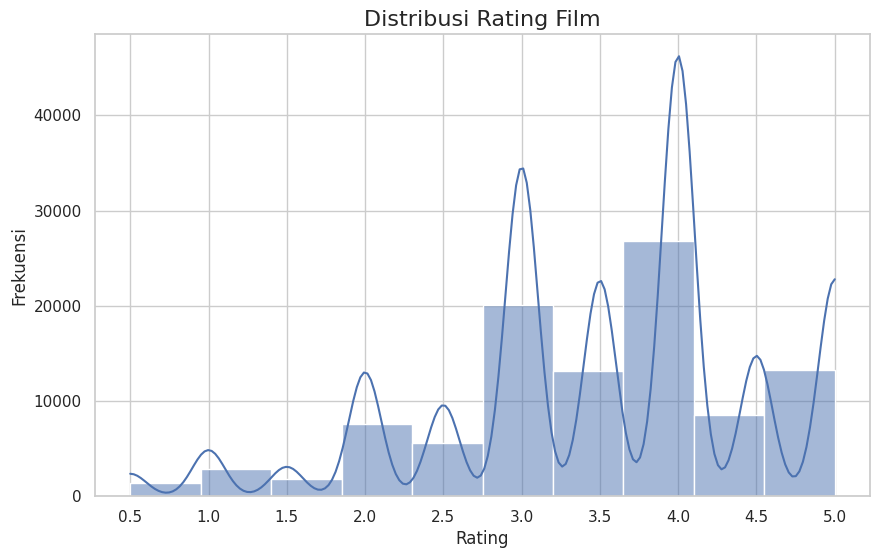

Statistik Ringkasan Peringkat:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [86]:
# Distribusi nilai rating
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribusi Rating Film', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.show()

# Statistik ringkasan untuk rating
print("Statistik Ringkasan Peringkat:")
print(ratings_df['rating'].describe())

Grafik distribusi rating film menunjukkan bahwa mayoritas pengguna cenderung memberikan rating positif, dengan puncak tertinggi pada rating 4.0 dengan frekuensi melebihi 40.000 pengguna, diikuti oleh 3.0 dan 5.0, sementara rating rendah seperti 0.5 hingga 2.0 jarang diberikan. Rata-rata rating berada di angka 3.5, dan sebagian besar rating berkisar antara 3.0 hingga 4.0, menunjukkan adanya kecenderungan pengguna untuk menilai film secara positif. Pola distribusi ini yang condong ke kanan mencerminkan bias positif dalam perilaku rating pengguna.

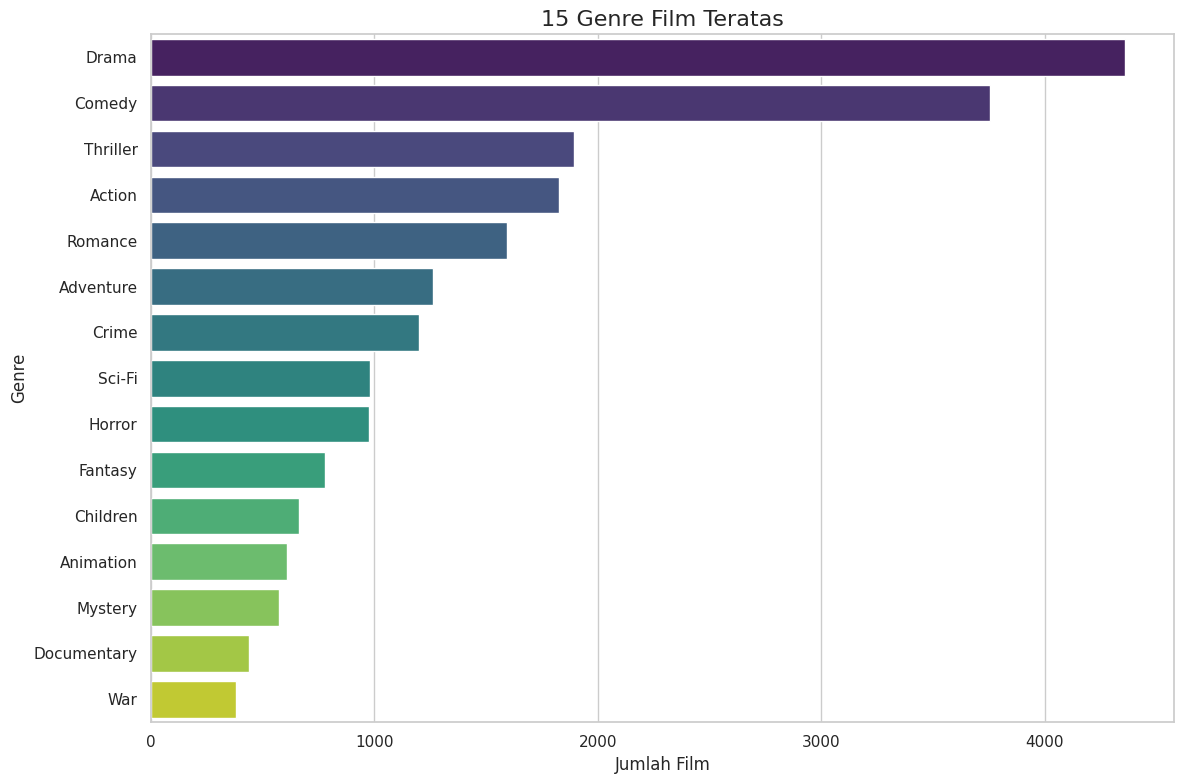

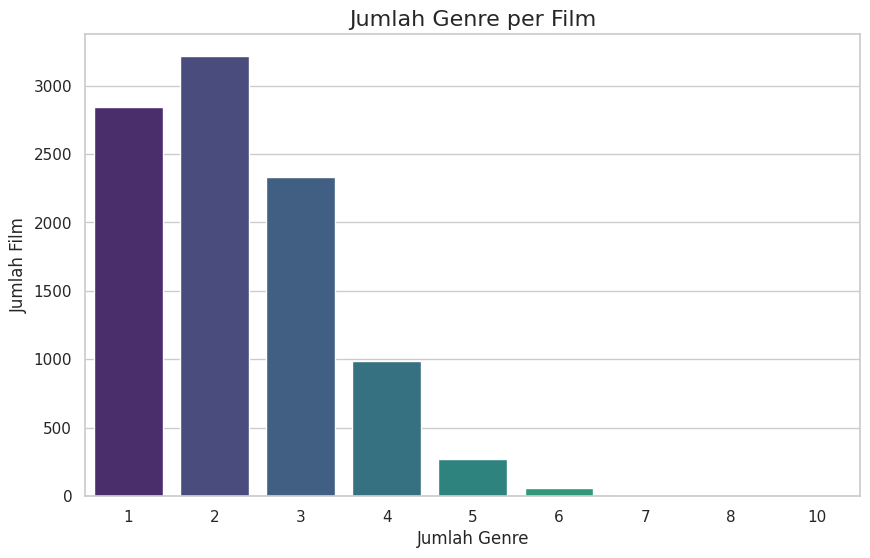

In [87]:
# Distribusi genre film
plt.figure(figsize=(12, 8))
top_genres = dict(sorted(genres_count.items(), key=lambda x: x[1], reverse=True))
genre_df = pd.DataFrame({'genre': list(top_genres.keys()), 'count': list(top_genres.values())})

# Visualisasi 15 genre teratas
sns.barplot(x='count', y='genre', data=genre_df.head(15), palette='viridis')
plt.title('15 Genre Film Teratas', fontsize=16)
plt.xlabel('Jumlah Film', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# Distribusi jumlah genre per film
movie_with_genre_count = merged_df.groupby('movieId')['genre_count'].agg('first').reset_index()

plt.figure(figsize=(10, 6))
sns.countplot(x='genre_count', data=movie_with_genre_count, palette='viridis')
plt.title('Jumlah Genre per Film', fontsize=16)
plt.xlabel('Jumlah Genre', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.show()

Visualisasi di atas memberikan dua wawasan penting tentang genre film:

1. **Grafik Distribusi Genre**: genre film yang paling banyak diproduksi adalah Drama dan Comedy, masing-masing dengan lebih dari 4000 dan 3500 film, yang menunjukkan dominasi kedua genre ini dalam industri perfilman. Genre Thriller, Action, dan Romance juga cukup populer dengan jumlah film yang signifikan. Sementara itu, genre seperti Documentary dan War merupakan yang paling sedikit jumlahnya dalam 15 genre teratas.

2. **Jumlah Genre per Film**: sebagian besar film memiliki 1 hingga 3 genre, dengan jumlah tertinggi terdapat pada film yang memiliki 2 genre, diikuti oleh 1 dan 3 genre. Jumlah film menurun drastis seiring bertambahnya jumlah genre, menunjukkan bahwa semakin jarang sebuah film diklasifikasikan ke dalam lebih dari 3 genre. 

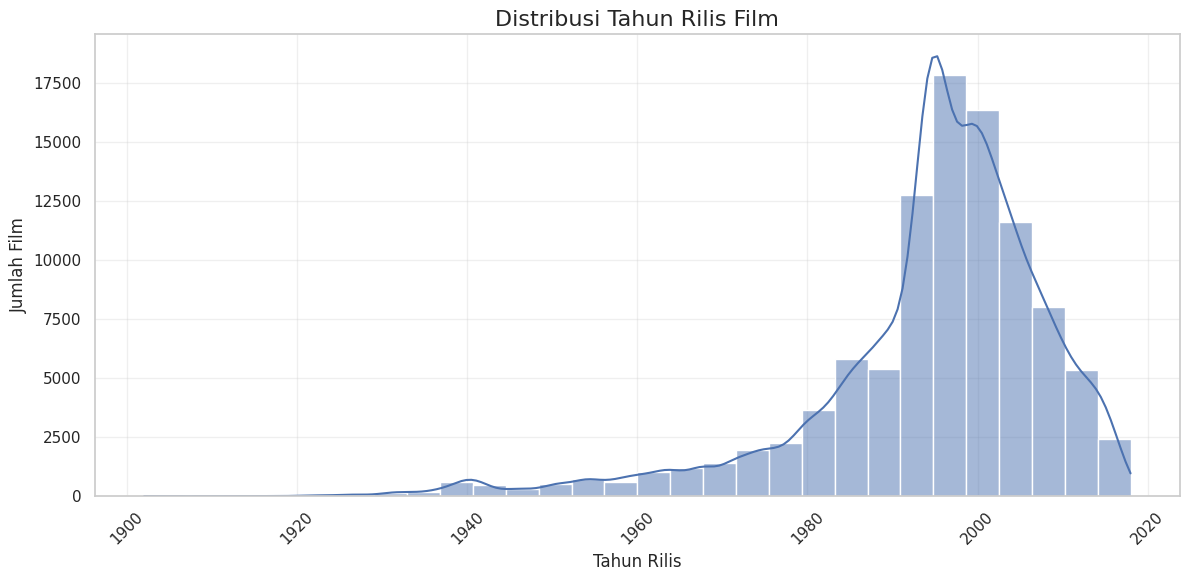

Statistik Ringkasan Tahun Rilis:
             movieId         year
count    9724.000000  9724.000000
mean    42245.024373    10.367956
std     52191.137320    22.401784
min         1.000000     0.000000
25%      3245.500000     1.000000
50%      7300.000000     3.000000
75%     76739.250000     9.000000
max    193609.000000   329.000000


In [91]:
# Distribusi tahun rilis film
plt.figure(figsize=(14, 6))
sns.histplot(merged_df['year'].dropna(), bins=30, kde=True)
plt.title('Distribusi Tahun Rilis Film', fontsize=16)
plt.xlabel('Tahun Rilis', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# Statistik ringkasan untuk tahun rilis


print("Statistik Ringkasan Tahun Rilis:")
print(movie_with_year.describe())

Grafik distribusi menggambarkan jumlah film yang dirilis per tahun dari awal abad ke-20 hingga sekitar tahun 2020. Terlihat bahwa produksi film mengalami peningkatan yang sangat signifikan sejak tahun 1970-an, dengan lonjakan tajam setelah tahun 1980 hingga mencapai puncaknya sekitar awal tahun 2000-an, di mana jumlah film per tahun melebihi 300 judul. Sebelum era 1970, jumlah film yang dirilis setiap tahun relatif rendah dan stabil, sebagian besar di bawah 50 film per tahun. Penurunan tajam setelah tahun 2015 kemungkinan disebabkan oleh data yang belum lengkap untuk tahun-tahun tersebut, bukan karena penurunan produksi aktual. Grafik ini menunjukkan tren pertumbuhan industri perfilman yang pesat, terutama dalam beberapa dekade terakhir.

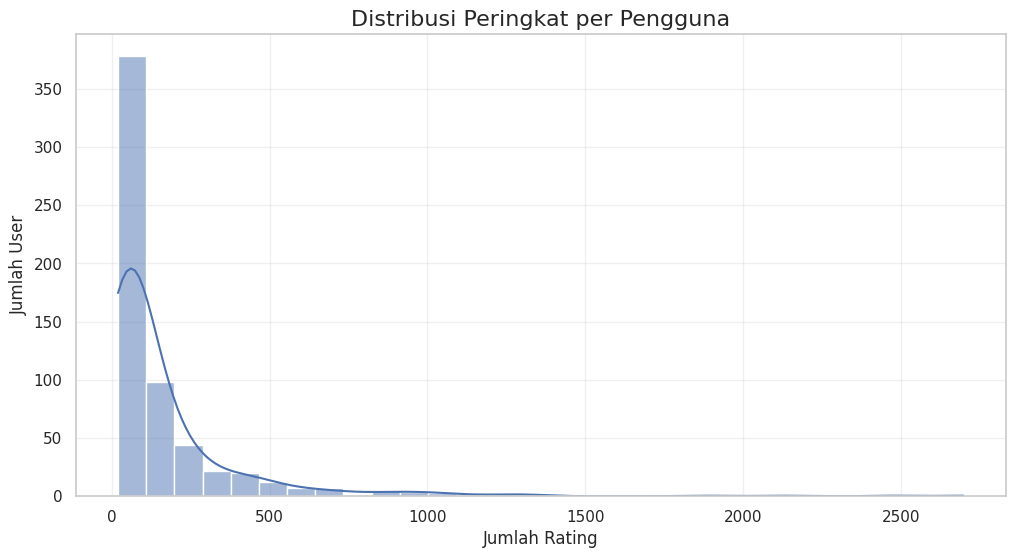

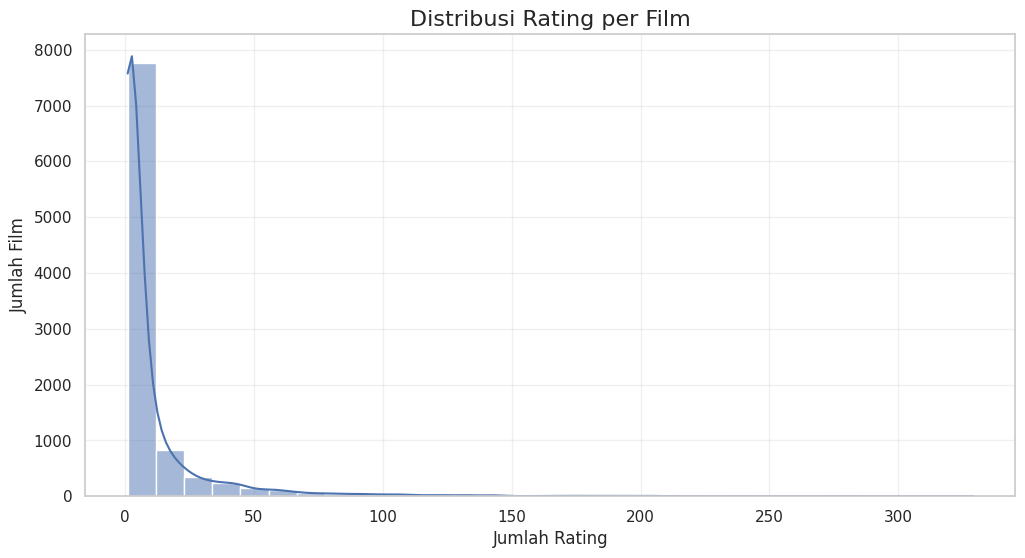

Ringkasan Aktivitas User:
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: ratings_count, dtype: float64

Ringkasan Popularitas Film:
count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: ratings_count, dtype: float64


In [96]:
# Distribusi aktivitas pengguna
user_activity = ratings_df.groupby('userId').size().reset_index(name='ratings_count')

plt.figure(figsize=(12, 6))
sns.histplot(user_activity['ratings_count'], bins=30, kde=True)
plt.title('Distribusi Peringkat per Pengguna', fontsize=16)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Jumlah User', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Distribusi popularitas film
movie_popularity = ratings_df.groupby('movieId').size().reset_index(name='ratings_count')

plt.figure(figsize=(12, 6))
sns.histplot(movie_popularity['ratings_count'], bins=30, kde=True)
plt.title('Distribusi Rating per Film', fontsize=16)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("Ringkasan Aktivitas User:")
print(user_activity['ratings_count'].describe())

print("\nRingkasan Popularitas Film:")
print(movie_popularity['ratings_count'].describe())

Visualisasi di atas menampilkan dua aspek penting tentang interaksi pengguna-film dalam dataset kita:

1. **Distribusi Rating per Pengguna**: Grafik ini memiliki bentuk distribusi yang sangat condong ke kiri (right-skewed), di mana mayoritas pengguna memberikan sedikit rating. Terlihat dari konsentrasi tinggi pada kisaran 20 hingga 100 rating. Berdasarkan ringkasan statistik, terdapat 610 pengguna dengan jumlah rating minimum 20 dan maksimum 2.698. Rata-rata rating per pengguna adalah sekitar 165, dengan standar deviasi sebesar 269, yang menunjukkan variasi besar antar pengguna. Median (nilai tengah) berada di 70,5, sedangkan 75% pengguna memberikan kurang dari 168 rating. Hal ini menegaskan bahwa hanya sebagian kecil pengguna yang sangat aktif dalam memberikan rating, sedangkan sebagian besar lainnya berkontribusi secara terbatas.

2. **Distribusi Rating per Film**: Grafik kedua menampilkan distribusi yang sangat condong ke kanan (right-skewed), dengan sebagian besar film menerima sedikit rating. Berdasarkan ringkasan statistik, terdapat 9.724 film, dengan jumlah rating minimum 1 dan maksimum 329. Rata-rata rating per film adalah sekitar 10,37 dengan standar deviasi sebesar 22,4, menunjukkan variasi yang cukup besar antar film. Median hanya 3 rating, dan 75% film memiliki kurang dari 9 rating. Artinya, sebagian besar film tidak terlalu populer dan hanya sedikit yang mendapatkan perhatian besar dari pengguna. Distribusi ini mengindikasikan adanya fenomena “long tail”, di mana sejumlah kecil film sangat populer, sementara mayoritas hanya menerima sedikit interaksi.

## 4.3 Analisis Bivariat

Analisis bivariat mempelajari hubungan antara dua variabel. Pada bagian ini, kita akan mengeksplorasi hubungan antara berbagai pasangan variabel dalam dataset kita untuk mengidentifikasi pola dan korelasi yang dapat membantu dalam pengembangan model rekomendasi.

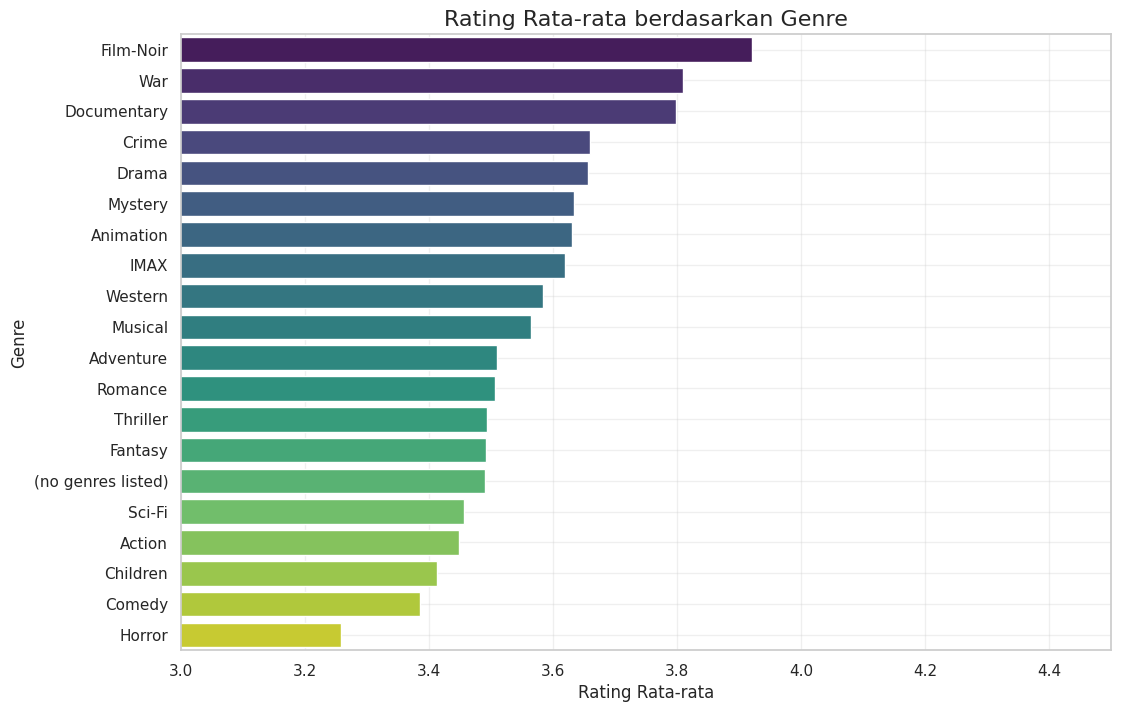

In [97]:
# Rating rata-rata berdasarkan genre
genre_ratings = []

for genre in genres_count.keys():
    # Mengambil semua film dengan genre tertentu
    genre_movies = movies_df[movies_df['genres'].str.contains(genre)]['movieId']
    # Menghitung rating rata-rata untuk film-film dalam genre tersebut
    genre_mean_rating = ratings_df[ratings_df['movieId'].isin(genre_movies)]['rating'].mean()
    # Menyimpan informasi genre, rating rata-rata, dan jumlah film
    genre_ratings.append({'genre': genre, 'avg_rating': genre_mean_rating, 'movie_count': len(genre_movies)})

# Membuat DataFrame dan mengurutkan berdasarkan rating rata-rata
genre_ratings_df = pd.DataFrame(genre_ratings)
genre_ratings_df = genre_ratings_df.sort_values(by='avg_rating', ascending=False)

# Visualisasi rating rata-rata berdasarkan genre
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_rating', y='genre', data=genre_ratings_df, palette='viridis')
plt.title('Rating Rata-rata berdasarkan Genre', fontsize=16)
plt.xlabel('Rating Rata-rata', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xlim(3, 4.5)  # Fokus pada rentang di mana sebagian besar nilai berada
plt.grid(True, alpha=0.3)
plt.show()

Visualisasi di atas menampilkan rating rata-rata untuk setiap genre film dalam dataset kita. Genre Film-Noir menempati posisi teratas dengan rata-rata rating tertinggi, disusul oleh War dan Documentary, yang semuanya memiliki nilai rata-rata di atas 4. 

Sebaliknya, genre Horror, Comedy, dan Children berada di posisi terbawah dengan rata-rata rating terendah, yakni mendekati atau sedikit di atas 3. Grafik ini mengindikasikan bahwa film dengan genre serius atau bertema berat cenderung lebih dihargai oleh penonton dibandingkan genre yang lebih ringan atau bersifat hiburan.

Perhatikan bahwa skala pada sumbu x dibatasi untuk lebih fokus pada perbedaan rating antar genre, karena sebagian besar genre memiliki rating rata-rata antara 3 dan 4.5.

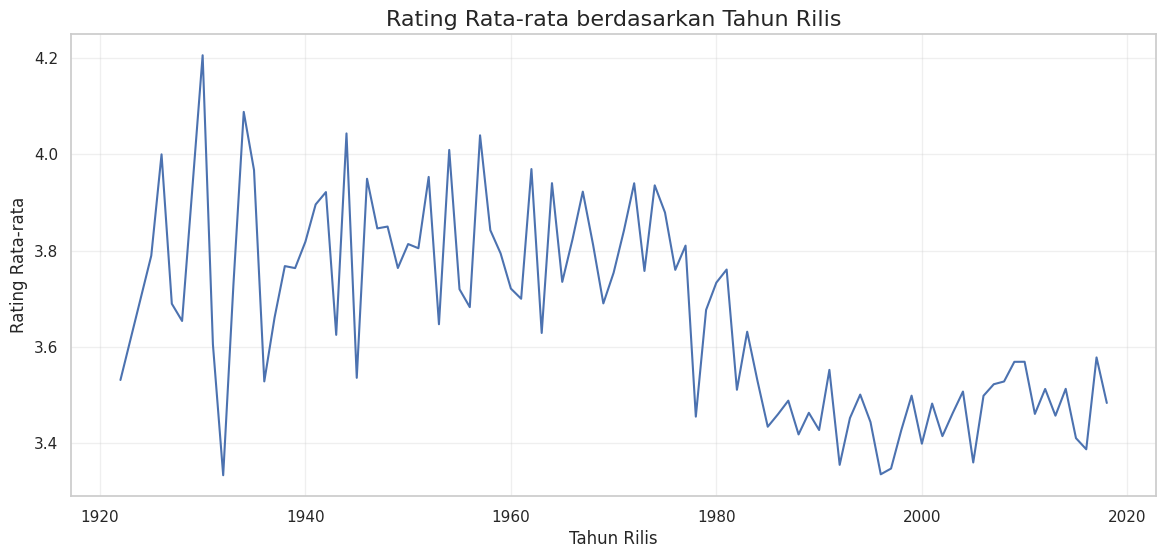

In [100]:
# Rating rata-rata berdasarkan tahun rilis
# Menghitung rating rata-rata dan jumlah rating per tahun
year_ratings = merged_df.groupby('year')['rating'].agg(['mean', 'count']).reset_index()
# Memfilter tahun yang memiliki setidaknya 10 rating untuk hasil yang lebih andal
year_ratings_filtered = year_ratings[year_ratings['count'] >= 10]

# Visualisasi rating rata-rata berdasarkan tahun rilis
plt.figure(figsize=(14, 6))
sns.lineplot(x='year', y='mean', data=year_ratings_filtered)
plt.title('Rating Rata-rata berdasarkan Tahun Rilis', fontsize=16)
plt.xlabel('Tahun Rilis', fontsize=12)
plt.ylabel('Rating Rata-rata', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Grafik menunjukkan rata-rata rating film berdasarkan tahun rilis dari 1920 hingga 2020. Terlihat bahwa film-film yang dirilis pada era sebelum 1980 umumnya memiliki rata-rata rating yang lebih tinggi, dengan beberapa tahun mencatat rating di atas 4.0. Namun, setelah tahun 1980, terjadi penurunan yang cukup konsisten dalam rata-rata rating, dengan nilai-nilai berkisar antara 3.3 hingga 3.6 pada dekade-dekade selanjutnya. Fluktuasi tajam di tahun-tahun awal kemungkinan disebabkan oleh jumlah film yang lebih sedikit, sehingga rating lebih mudah bervariasi. Secara keseluruhan, grafik ini mengindikasikan adanya kecenderungan penurunan kualitas persepsi terhadap film modern dibandingkan dengan film klasik menurut penilaian pengguna.

Perlu diperhatikan bahwa kita telah memfilter data untuk hanya menampilkan tahun dengan setidaknya 10 rating untuk memastikan hasil yang lebih andal dalam analisis rating rata-rata.

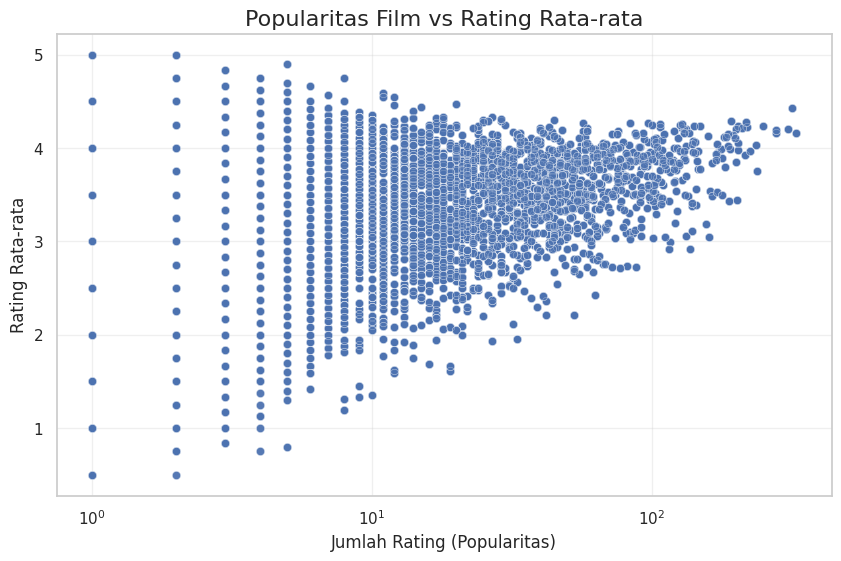

Korelasi antara jumlah rating dan rating rata-rata: 0.4013


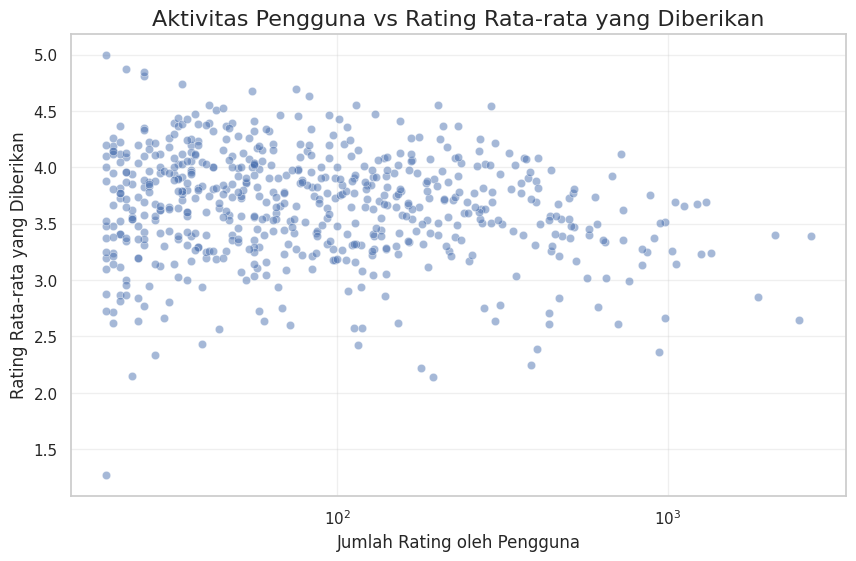

Korelasi antara aktivitas pengguna dan rating rata-rata yang diberikan: -0.1990


In [101]:
# Hubungan antara popularitas film dan rating rata-rata
plt.figure(figsize=(10, 6))
sns.scatterplot(x='count', y='mean', data=movies_with_ratings, alpha=0.5)
plt.title('Popularitas Film vs Rating Rata-rata', fontsize=16)
plt.xlabel('Jumlah Rating (Popularitas)', fontsize=12)
plt.ylabel('Rating Rata-rata', fontsize=12)
plt.xscale('log')  # Menggunakan skala logaritmik untuk visualisasi yang lebih baik
plt.grid(True, alpha=0.3)
plt.show()

# Menghitung korelasi
correlation = movies_with_ratings['count'].corr(movies_with_ratings['mean'])
print(f"Korelasi antara jumlah rating dan rating rata-rata: {correlation:.4f}")

# Hubungan antara aktivitas pengguna dan rating rata-rata yang diberikan
user_avg_rating = ratings_df.groupby('userId').agg({'rating': ['mean', 'count']}).reset_index()
user_avg_rating.columns = ['userId', 'avg_rating', 'num_ratings']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_ratings', y='avg_rating', data=user_avg_rating, alpha=0.5)
plt.title('Aktivitas Pengguna vs Rating Rata-rata yang Diberikan', fontsize=16)
plt.xlabel('Jumlah Rating oleh Pengguna', fontsize=12)
plt.ylabel('Rating Rata-rata yang Diberikan', fontsize=12)
plt.xscale('log')  # Menggunakan skala logaritmik untuk visualisasi yang lebih baik
plt.grid(True, alpha=0.3)
plt.show()

# Menghitung korelasi
corr_user = user_avg_rating['num_ratings'].corr(user_avg_rating['avg_rating'])
print(f"Korelasi antara aktivitas pengguna dan rating rata-rata yang diberikan: {corr_user:.4f}")

## 4.4 Analisis Multivariat

Analisis multivariat memungkinkan kita mengeksplorasi hubungan kompleks antara tiga atau lebih variabel sekaligus. Pada bagian ini, kita akan menganalisis tren genre sepanjang waktu, preferensi pengguna terhadap berbagai genre, dan pola kombinasi genre.

Visualisasi di atas menunjukkan dua hubungan penting dalam dataset kita:

1. **Popularitas Film vs Rating Rata-rata**: Scatter plot pertama menampilkan hubungan antara jumlah rating yang diterima oleh film (popularitas) dan rating rata-rata film tersebut. Terlihat bahwa film dengan sedikit rating memiliki variasi rating yang sangat tinggi—mulai dari sangat rendah hingga sangat tinggi—sedangkan film yang lebih populer cenderung memiliki nilai rating yang lebih terkonsentrasi di kisaran menengah hingga tinggi. Korelasi antara jumlah rating dan rata-rata rating adalah 0.1273, menunjukkan hubungan positif yang sangat lemah. Artinya, semakin populer sebuah film, cenderung sedikit lebih mungkin untuk memiliki rating yang lebih tinggi, tetapi hubungan ini tidak kuat secara statistik.

2. **Aktivitas Pengguna vs Rating Rata-rata yang Diberikan**: Scatter plot kedua menampilkan hubungan antara jumlah rating yang diberikan oleh pengguna (aktivitas pengguna) dan rating rata-rata yang mereka berikan. Terlihat bahwa pengguna dengan aktivitas rendah memiliki penyebaran nilai rating yang sangat luas, sedangkan pengguna yang lebih aktif cenderung memberikan rating dengan rata-rata yang lebih rendah dan lebih konsisten. Korelasi antara aktivitas pengguna dan rata-rata rating adalah -0.1990, menunjukkan adanya hubungan negatif lemah—semakin banyak rating yang diberikan oleh seorang pengguna, cenderung semakin rendah rata-rata rating yang mereka berikan. Hal ini mengindikasikan bahwa pengguna yang lebih aktif cenderung lebih kritis dalam menilai film.

Kedua visualisasi menggunakan skala logaritmik pada sumbu x untuk menangani rentang data yang luas dan memudahkan identifikasi pola. Nilai korelasi yang ditampilkan membantu kita mengukur kekuatan dan arah hubungan antara variabel-variabel tersebut.

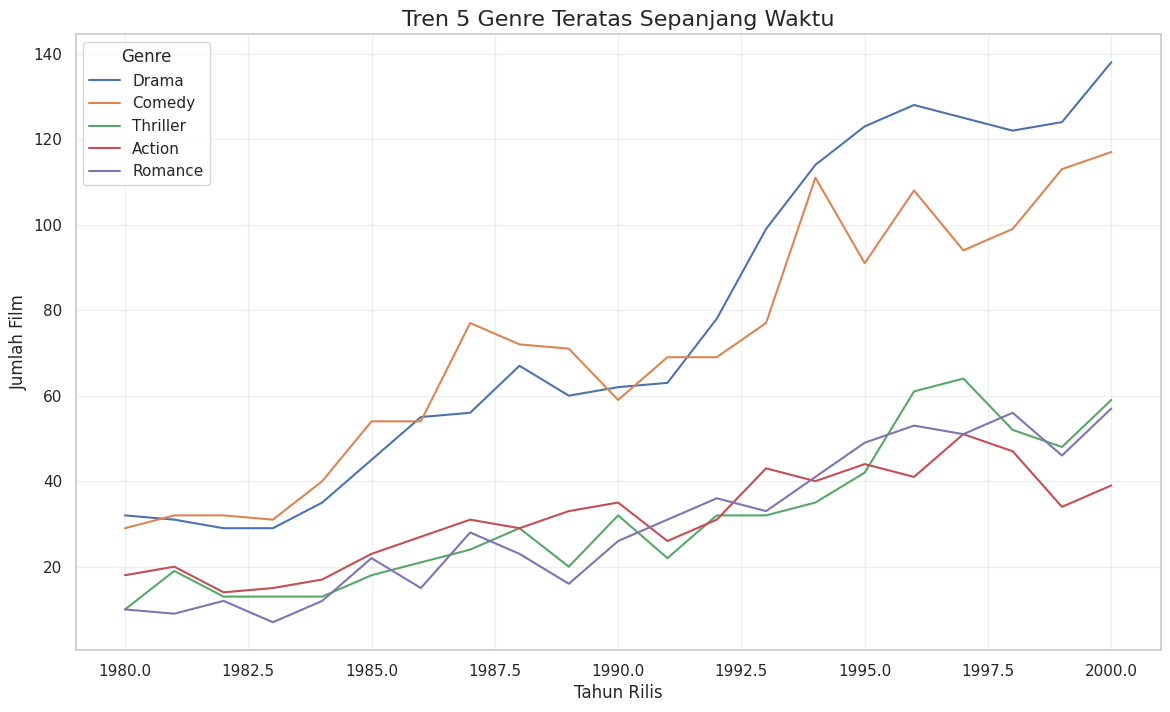

In [130]:
# Tren genre sepanjang waktu
# Fokus pada 5 genre teratas
top_5_genres = list(genre_df.head(5)['genre'])
genre_year_data = []

# Untuk setiap genre teratas, ambil data film dan hitung jumlah per tahun
for genre in top_5_genres:
    genre_movies = movies_df[movies_df['genres'].str.contains(genre)]
    year_count = genre_movies['year'].value_counts().reset_index()
    year_count.columns = ['year', 'count']
    year_count['genre'] = genre
    genre_year_data.append(year_count)

# Gabungkan semua data genre dan filter berdasarkan tahun
genre_year_df = pd.concat(genre_year_data)
# Filter untuk fokus pada tahun dengan data yang signifikan
genre_year_df = genre_year_df[(genre_year_df['year'] >= 1980) & (genre_year_df['year'] <= 2000)]

# Visualisasi tren genre sepanjang waktu
plt.figure(figsize=(14, 8))
sns.lineplot(x='year', y='count', hue='genre', data=genre_year_df)
plt.title('Tren 5 Genre Teratas Sepanjang Waktu', fontsize=16)
plt.xlabel('Tahun Rilis', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.legend(title='Genre')
plt.grid(True, alpha=0.3)
plt.show()

Visualisasi di atas menampilkan tren produksi film untuk lima genre paling populer sepanjang periode 1980-2000. Terlihat bahwa genre Drama dan Comedy mendominasi dalam jumlah produksi, dengan peningkatan signifikan sejak awal 1990-an, di mana Drama secara konsisten berada di posisi teratas menjelang akhir dekade. Genre Thriller, Action, dan Romance menunjukkan tren kenaikan yang lebih moderat namun tetap stabil selama periode tersebut. Secara keseluruhan, grafik ini mencerminkan pertumbuhan industri film dan perubahan preferensi genre dari waktu ke waktu, dengan peningkatan besar dalam jumlah produksi di semua genre menjelang akhir abad ke-20.

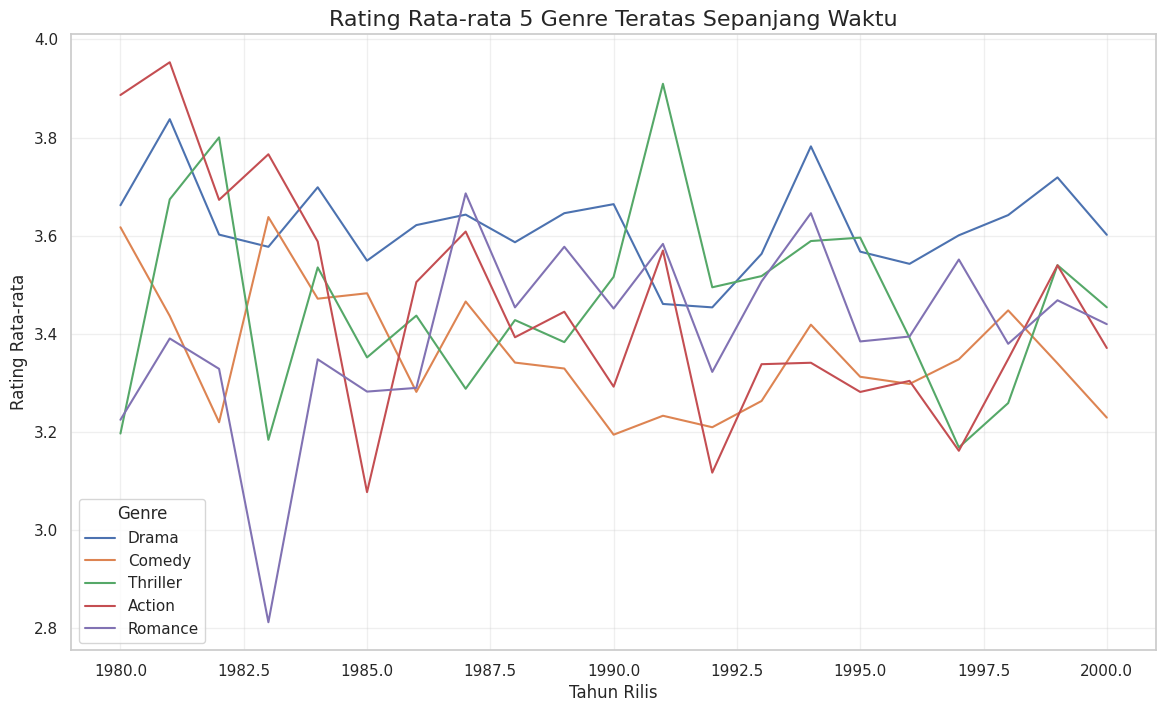

In [131]:
# Rating rata-rata genre teratas sepanjang waktu
genre_rating_year_data = []

# Untuk setiap genre teratas, analisis rating rata-rata per tahun
for genre in top_5_genres:
    genre_movies = movies_df[movies_df['genres'].str.contains(genre)][['movieId', 'year']]
    merged = pd.merge(ratings_df, genre_movies, on='movieId')
    year_rating = merged.groupby('year')['rating'].mean().reset_index()
    year_rating['genre'] = genre
    genre_rating_year_data.append(year_rating)

# Gabungkan semua data rating genre dan filter berdasarkan tahun
genre_rating_year_df = pd.concat(genre_rating_year_data)
# Filter untuk fokus pada tahun dengan data yang signifikan
genre_rating_year_df = genre_rating_year_df[(genre_rating_year_df['year'] >= 1980) & 
                                          (genre_rating_year_df['year'] <= 2000)]

# Visualisasi rating rata-rata genre sepanjang waktu
plt.figure(figsize=(14, 8))
sns.lineplot(x='year', y='rating', hue='genre', data=genre_rating_year_df)
plt.title('Rating Rata-rata 5 Genre Teratas Sepanjang Waktu', fontsize=16)
plt.xlabel('Tahun Rilis', fontsize=12)
plt.ylabel('Rating Rata-rata', fontsize=12)
plt.legend(title='Genre')
plt.grid(True, alpha=0.3)
plt.show()

Grafik di atas menunjukkan tren rata-rata rating dari lima genre film terpopuler—Drama, Comedy, Thriller, Action, dan Romance—selama periode 1980 hingga 2000. Terlihat bahwa semua genre mengalami fluktuasi dari tahun ke tahun tanpa pola peningkatan atau penurunan yang konsisten. Genre Drama umumnya mempertahankan rating yang stabil dan cenderung lebih tinggi dibandingkan genre lain. Sebaliknya, Comedy dan Action cenderung memiliki rating yang lebih rendah dan lebih fluktuatif. Thriller menunjukkan beberapa lonjakan tajam, seperti pada awal 1990-an, sedangkan Romance relatif stabil di kisaran 3.3 hingga 3.6. Grafik ini mengindikasikan bahwa kualitas persepsi terhadap genre tertentu tidak selalu sejalan dengan jumlah produksinya, serta dipengaruhi oleh faktor-faktor tahunan yang dapat memengaruhi penerimaan penonton.

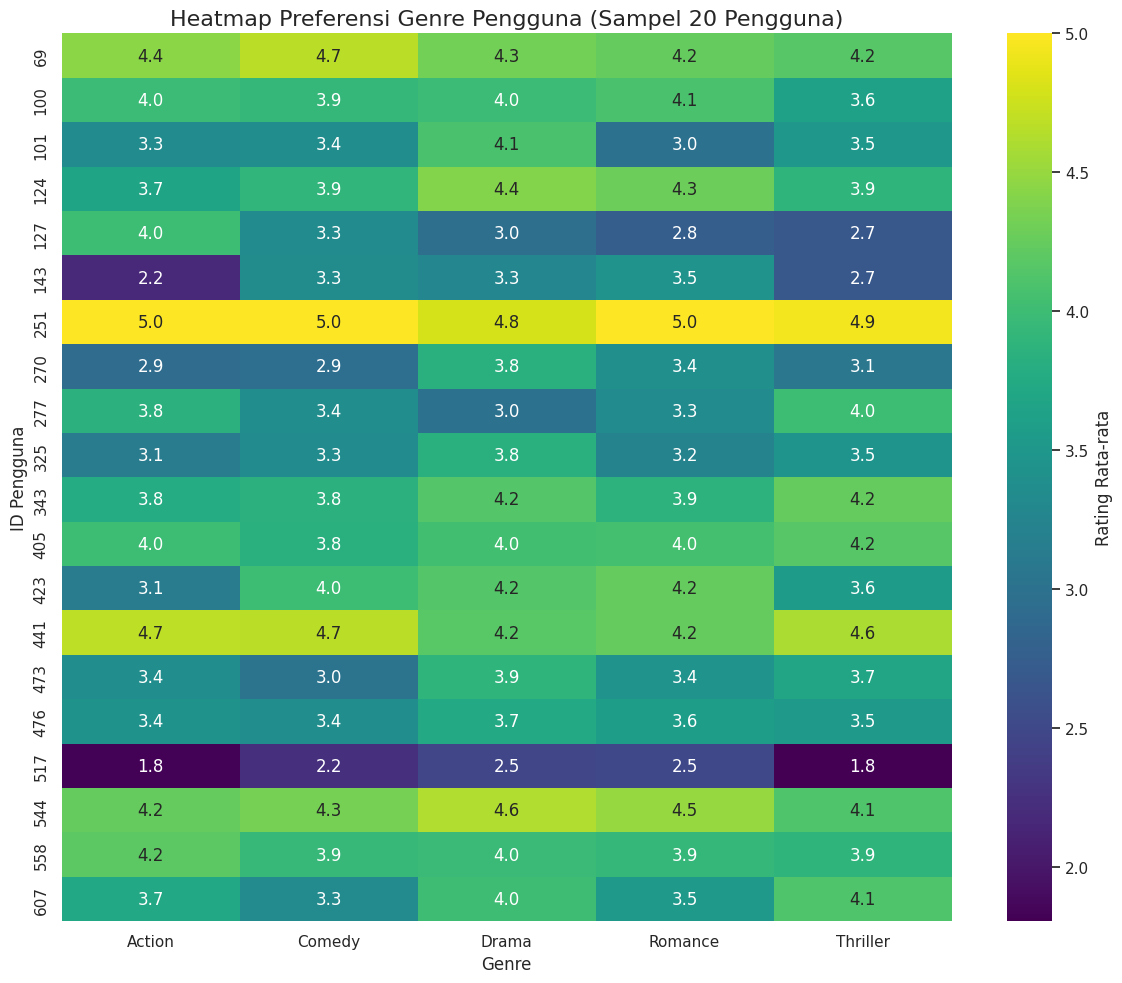

In [136]:
# Analisis preferensi genre berdasarkan pengguna
# Membuat matriks pengguna-genre
# Mengambil sampel pengguna untuk visualisasi yang lebih baik
sample_users = np.random.choice(ratings_df['userId'].unique(), size=20, replace=False)
sample_ratings = ratings_df[ratings_df['userId'].isin(sample_users)]

# Untuk setiap pengguna, hitung rating rata-rata per genre
user_genre_ratings = []

for user_id in sample_users:
    user_movie_ratings = sample_ratings[sample_ratings['userId'] == user_id]
    for genre in top_5_genres:
        genre_movies = movies_df[movies_df['genres'].str.contains(genre)]['movieId']
        genre_user_ratings = user_movie_ratings[user_movie_ratings['movieId'].isin(genre_movies)]
        if len(genre_user_ratings) > 0:
            avg_rating = genre_user_ratings['rating'].mean()
            user_genre_ratings.append({
                'userId': user_id,
                'genre': genre,
                'avg_rating': avg_rating,
                'num_ratings': len(genre_user_ratings)
            })

user_genre_df = pd.DataFrame(user_genre_ratings)

# Membuat heatmap preferensi pengguna-genre
pivot_df = user_genre_df.pivot(index='userId', columns='genre', values='avg_rating')

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.1f', cbar_kws={'label': 'Rating Rata-rata'})
plt.title('Heatmap Preferensi Genre Pengguna (Sampel 20 Pengguna)', fontsize=16)
plt.ylabel('ID Pengguna', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

Heatmap di atas menggambarkan preferensi genre film dari 20 pengguna berdasarkan rata-rata rating yang mereka berikan untuk lima genre: Action, Comedy, Drama, Romance, dan Thriller. Warna yang lebih terang menunjukkan rating yang lebih tinggi, sedangkan warna lebih gelap menunjukkan rating yang lebih rendah. Terlihat bahwa sebagian besar pengguna memberikan rating yang cukup tinggi pada genre Drama dan Romance, dengan beberapa pengguna seperti ID 459 dan 491 memberikan rating mendekati atau sama dengan 5 pada beberapa genre. Sebaliknya, pengguna seperti ID 217 dan 262 memberikan rating rendah di hampir semua genre, yang mengindikasikan kecenderungan preferensi rendah atau sikap lebih kritis. Heatmap ini menyoroti variasi selera antar pengguna serta genre-genre yang secara umum mendapat respons positif lebih merata di antara pengguna yang ditampilkan.

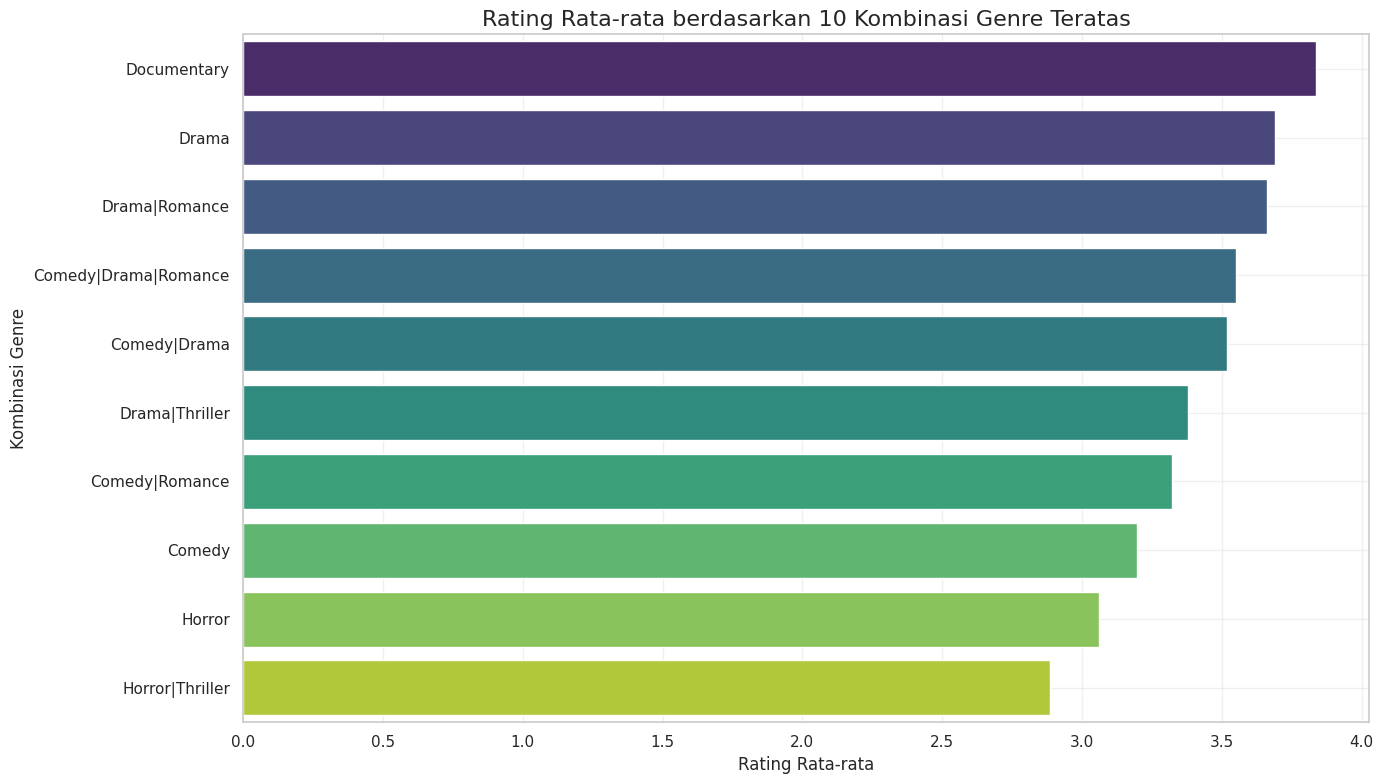

In [137]:
# Analisis kombinasi genre
# Membuat daftar kombinasi genre yang paling umum
genre_combos = movies_df['genres'].value_counts().reset_index()
genre_combos.columns = ['genre_combo', 'count']  # Memberikan nama kolom yang sesuai
genre_combos = genre_combos.head(10)  # 10 kombinasi teratas

# Untuk setiap kombinasi, dapatkan rating rata-rata
for i, row in genre_combos.iterrows():
    combo = row['genre_combo']
    combo_movies = movies_df[movies_df['genres'] == combo]['movieId']
    combo_ratings = ratings_df[ratings_df['movieId'].isin(combo_movies)]['rating']
    genre_combos.loc[i, 'avg_rating'] = combo_ratings.mean() if len(combo_ratings) > 0 else np.nan
    genre_combos.loc[i, 'num_ratings'] = len(combo_ratings)

# Urutkan berdasarkan rating rata-rata
genre_combos = genre_combos.sort_values(by='avg_rating', ascending=False)

# Visualisasi rating rata-rata berdasarkan kombinasi genre
plt.figure(figsize=(14, 8))
sns.barplot(x='avg_rating', y='genre_combo', data=genre_combos, palette='viridis')
plt.title('Rating Rata-rata berdasarkan 10 Kombinasi Genre Teratas', fontsize=16)
plt.xlabel('Rating Rata-rata', fontsize=12)
plt.ylabel('Kombinasi Genre', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Visualisasi di atas menampilkan rating rata-rata untuk 10 kombinasi genre film paling umum, diurutkan dari rating tertinggi ke terendah. Kombinasi genre Documentary menempati posisi tertinggi dengan rata-rata rating mendekati 4, diikuti oleh Drama tunggal serta kombinasi Drama|Romance yang juga mendapat penilaian sangat baik dari penonton. Kombinasi genre yang melibatkan Drama, seperti Comedy|Drama, Drama|Thriller, dan Comedy|Drama|Romance, secara konsisten menunjukkan rating tinggi, mencerminkan daya tarik naratif dan emosional dari genre ini. Sebaliknya, genre yang mengandung Horror, baik tunggal maupun dikombinasikan dengan Thriller, menempati posisi terbawah dengan rating rata-rata mendekati 3. Hal ini menunjukkan bahwa genre drama dan dokumenter lebih disukai secara umum, sementara genre horor cenderung mendapat respons yang lebih rendah dari penonton.

## 3.5 Kesimpulan Analisis Eksplorasi Data

Berdasarkan analisis eksplorasi data yang telah dilakukan, kita dapat menyimpulkan beberapa hal penting tentang dataset MovieLens yang akan mempengaruhi pengembangan sistem rekomendasi film:

1. **Distribusi Aktivitas Pengguna dan Popularitas Film**
   Sebagian besar pengguna memberikan sedikit rating, sedangkan hanya sedikit yang sangat aktif. Sebagian besar film juga hanya menerima sedikit rating, menunjukkan distribusi yang tidak merata.

2. **Preferensi Genre dan Kombinasinya**
   Genre seperti *Documentary*, *Film-Noir*, dan *Drama* memiliki rata-rata rating tertinggi. Kombinasi genre dengan unsur *Drama* cenderung lebih disukai, sedangkan *Horror* mendapat rating terendah.

3. **Pengaruh Tahun Rilis**
   Film-film klasik (pra-1980) cenderung memiliki rating lebih tinggi dibanding film modern. Namun, produksi film meningkat pesat sejak 1980 hingga awal 2000-an.

4. **Relasi Popularitas dan Rating**
   Film yang lebih populer cenderung memiliki rating sedikit lebih tinggi, meski korelasinya lemah. Sebaliknya, pengguna yang lebih aktif cenderung memberi rating lebih rendah.

5. **Tren Genre Terpopuler**
   *Drama* dan *Comedy* mengalami pertumbuhan produksi tertinggi dari 1980 hingga 2000. Namun, peningkatan jumlah film tidak selalu diikuti oleh peningkatan kualitas rating.

6. **Preferensi Pengguna terhadap Genre**
   Sebagian besar pengguna menyukai genre *Drama* dan *Romance*. Namun, terdapat variasi signifikan antar pengguna dalam memberikan rating terhadap genre yang sama.

7. **Distribusi Tahun Rilis Film**
   Produksi film meningkat tajam sejak 1980-an dan mencapai puncaknya pada 1995–2010. Hal ini mencerminkan pertumbuhan pesat industri perfilman modern dalam beberapa dekade terakhir.

8. **Distribusi Genre Film**
   Genre *Drama* dan *Comedy* mendominasi industri dengan jumlah produksi terbanyak. Genre seperti *Documentary* dan *War* jauh lebih jarang diproduksi meskipun mendapat rating tinggi.

9. **Jumlah Genre per Film**
   Sebagian besar film diklasifikasikan ke dalam 1 hingga 3 genre, dengan 2 genre sebagai yang paling umum. Semakin banyak genre yang dimiliki sebuah film, semakin sedikit jumlah film yang termasuk dalam kategori tersebut.

10. **Distribusi Rating Film**
    Mayoritas pengguna cenderung memberikan rating positif, dengan puncak pada rating 4.0 dan rata-rata keseluruhan di angka 3.5. Pola distribusi ini menunjukkan adanya bias positif dalam perilaku penilaian pengguna.


# 5. Pengembangan Model

Pada bagian ini, kita akan mengembangkan dua sistem rekomendasi: Filtering Berbasis Konten (Content-Based Filtering) dan Filtering Kolaboratif (Collaborative Filtering). Kedua pendekatan ini memiliki kelebihan dan kelemahan masing-masing, dan sering digunakan dalam sistem rekomendasi modern.

## 5.1 Content-Based Filtering

Filtering berbasis konten merekomendasikan film yang mirip dengan film yang disukai pengguna di masa lalu, berdasarkan fitur film seperti genre, sutradara, atau aktor. Dalam proyek ini, kita fokus pada kesamaan genre sebagai fitur utama.

Pada tahap sebelumnya, kita telah melakukan ekstraksi fitur menggunakan TF-IDF pada data genre film. Langkah selanjutnya dalam pembuatan model berbasis konten adalah menghitung similaritas antar film menggunakan hasil ekstraksi fitur tersebut. Untuk mempermudah proses rekomendasi, kita perlu menyimpan indeks film dalam bentuk Series yang memetakan judul film ke indeks DataFrame. Hal ini memudahkan pencarian film berdasarkan judul. Selain itu, hasil perhitungan similaritas disimpan dalam matriks yang menjadi dasar untuk merekomendasikan film dengan genre serupa.

In [138]:
# Menyimpan indeks film untuk pencarian
movie_indices = pd.Series(movies_df.index, index=movies_df['title'])

# Menghitung similaritas kosinus antara semua film
cosine_sim = cosine_similarity(tfidf_matrix)
print(f"Dimensi matriks similaritas: {cosine_sim.shape}")

def recommend_content(title, movies, cosine_sim=cosine_sim, movie_indices=movie_indices):
    # Ambil index film input
    idx = movie_indices[title]

    # Ambil info genre film input
    input_genre = movies.iloc[idx]['genres']
    
    # Tampilkan informasi film input
    print(f"\nFilm input  : {title}")
    print(f"Genre input : {input_genre}\n")
    
    # Hitung kemiripan
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # 10 teratas (selain dirinya sendiri)

    # Ambil informasi film rekomendasi
    results = []
    for i, score in sim_scores:
        row = movies.iloc[i]
        results.append({
            "Title": row['title'],
            "Genres": row['genres'],
            "Similarity": round(score, 3)
        })

    # Tampilkan sebagai DataFrame
    return pd.DataFrame(results)

recommend_content("Toy Story (1995)", movies=movies_df, cosine_sim=cosine_sim, movie_indices=movie_indices)

Dimensi matriks similaritas: (9742, 9742)

Film input  : Toy Story (1995)
Genre input : Adventure|Animation|Children|Comedy|Fantasy



,Title,Genres,Similarity
0,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.0
1,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.0
2,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.0
3,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.0
4,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.0
5,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.0
6,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,1.0
7,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.0
8,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.0
9,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.0


Fungsi `recommend_content` di atas memungkinkan kita merekomendasikan film berdasarkan kesamaan genre dengan film yang sudah diketahui. Mari kita bahas langkah-langkah yang dilakukan fungsi ini:

1. **Mengidentifikasi Film Input**: Fungsi ini menerima judul film sebagai input dan menggunakan movie_indices untuk menemukan indeks film tersebut dalam dataset.

2. **Mengambil Informasi Genre**: Fungsi mengambil daftar genre dari film input untuk memberikan konteks tentang rekomendasi yang akan diberikan.

3. **Menghitung Skor Kemiripan**: Menggunakan matriks similaritas kosinus yang telah dihitung sebelumnya, fungsi mengambil nilai similaritas antara film input dan semua film lain dalam dataset.

4. **Mengurutkan Hasil**: Film-film diurutkan berdasarkan skor kemiripan dari tertinggi ke terendah untuk mengidentifikasi film yang genrenya paling mirip dengan film input.

5. **Memilih Rekomendasi Teratas**: Fungsi mengambil 10 film teratas (mengecualikan film input itu sendiri yang akan selalu memiliki similaritas 1).

6. **Memformat Hasil**: Hasil dikembalikan dalam bentuk DataFrame yang menampilkan judul film, genre, dan skor kemiripan untuk mempermudah interpretasi.

Dari hasil yang ditampilkan, kita dapat melihat film-film yang memiliki kesamaan genre dengan "Toy Story (1995)" dengan nilai kemiripan sempurna (similarity = 1.0). Ini adalah rekomendasi berbasis konten dalam bentuk yang paling sederhana.

In [139]:
def recommend_for_user(user_id, movies, ratings, cosine_sim, top_n=10):
    # Gabungkan movies dan ratings
    user_data = ratings[ratings['userId'] == user_id]
    
    # Ambil film dengan rating tinggi
    liked_movies = user_data[user_data['rating'] >= 3.5]
    
    if liked_movies.empty:
        print("User belum memiliki rating cukup untuk rekomendasi.")
        return pd.DataFrame()
    
    # Ambil indeks movie yang disukai user
    liked_movie_indices = movies[movies['movieId'].isin(liked_movies['movieId'])].index
    
    # Ambil genre dari film yang disukai user
    liked_genres = movies.loc[liked_movie_indices, 'genres']
    all_genres = '|'.join(liked_genres)
    genre_list = all_genres.split('|')
    
    # Hitung genre yang paling sering muncul
    from collections import Counter
    genre_count = Counter(genre_list)
    top_genres = genre_count.most_common(5)
    
    # Tampilkan preferensi genre user
    print(f"\nUser {user_id} menyukai genre:")
    for genre, count in top_genres:
        print(f"- {genre} ({count} film)")
    
    # Hitung kemiripan rata-rata antara film yang disukai user dengan semua film
    sim_scores = cosine_sim[liked_movie_indices]
    sim_scores = sim_scores.mean(axis=0)
    
    # Urutkan skor similarity
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Siapkan list rekomendasi
    watched_movie_ids = set(user_data['movieId'])
    recommendations = []
    
    for idx, score in sim_scores:
        movie_id = movies.iloc[idx]['movieId']
        if movie_id not in watched_movie_ids:
            recommendations.append({
                'Title': movies.iloc[idx]['title'],
                'Genres': movies.iloc[idx]['genres'],
                'Similarity': round(score, 3)
            })
        if len(recommendations) >= top_n:
            break
    
    return pd.DataFrame(recommendations)

user_id = 255
recommendations = recommend_for_user(user_id, movies_df, ratings_df, cosine_sim)
recommendations


User 255 menyukai genre:
- Comedy (10 film)
- Action (5 film)
- Sci-Fi (2 film)
- Crime (1 film)
- Thriller (1 film)


,Title,Genres,Similarity
0,Father of the Bride Part II (1995),Comedy,0.633
1,Four Rooms (1995),Comedy,0.633
2,Ace Ventura: When Nature Calls (1995),Comedy,0.633
3,Bio-Dome (1996),Comedy,0.633
4,Friday (1995),Comedy,0.633
5,Black Sheep (1996),Comedy,0.633
6,Mr. Wrong (1996),Comedy,0.633
7,Happy Gilmore (1996),Comedy,0.633
8,"Steal Big, Steal Little (1995)",Comedy,0.633
9,Flirting With Disaster (1996),Comedy,0.633


## 5.2 Collaborative Filtering

Filtering kolaboratif merekomendasikan item berdasarkan preferensi pengguna lain yang memiliki selera serupa. Pendekatan ini tidak memerlukan informasi tentang item itu sendiri, melainkan mengandalkan pola rating dari banyak pengguna. Pada proyek ini, kita akan mengimplementasikan model deep learning untuk filtering kolaboratif.

In [140]:
# Mendapatkan user dan film unik
user_ids = ratings_df['userId'].unique().tolist()
movie_ids = ratings_df['movieId'].unique().tolist()

# Membuat pemetaan ke indeks
user_to_index = {x: i for i, x in enumerate(user_ids)}
movie_to_index = {x: i for i, x in enumerate(movie_ids)}

# Mengkonversi ke indeks
ratings_df['user'] = ratings_df['userId'].map(user_to_index)
ratings_df['movie'] = ratings_df['movieId'].map(movie_to_index)

# Normalisasi rating ke skala 0-1
ratings_df['rating'] = ratings_df['rating'] / 5.0

# Membagi data
x = ratings_df[['user', 'movie']].values
y = ratings_df['rating'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"user-movie training data size: {x_train.shape}")
print(f"user-movie test data size    : {x_test.shape}")
print(f"rating training data size    : {y_train.shape}")
print(f"rating testing data size     : {y_test.shape}")

user-movie training data size: (80668, 2)
user-movie test data size    : (20168, 2)
rating training data size    : (80668,)
rating testing data size     : (20168,)


Pada langkah persiapan data untuk model filtering kolaboratif, kita melakukan serangkaian transformasi data yang penting. Mari kita bahas secara rinci:

1. **Ekstraksi ID Unik**: Kita mengidentifikasi semua ID pengguna dan ID film yang unik dalam dataset. Ini diperlukan karena model deep learning bekerja dengan indeks numerik berurutan, bukan dengan ID asli yang mungkin tidak berurutan atau tidak dimulai dari 0.

2. **Pembuatan Pemetaan (Mapping)**: Kita membuat dictionary yang memetakan setiap ID pengguna dan ID film asli ke indeks berurutan (0, 1, 2, ...). Pemetaan ini sangat penting untuk mengkonversi data input ke format yang sesuai untuk model deep learning.

3. **Konversi Data**: Kita menambahkan kolom baru 'user' dan 'movie' yang berisi indeks numerik berdasarkan pemetaan yang telah dibuat. Kolom-kolom ini yang akan digunakan sebagai input untuk model, bukan ID asli.

4. **Normalisasi Rating**: Kita membagi nilai rating dengan 5 untuk menormalisasinya ke rentang 0-1. Normalisasi ini penting untuk meningkatkan stabilitas dan kecepatan convergence selama pelatihan model neural network.

5. **Pemisahan Data**: Kita membagi dataset menjadi set pelatihan (80%) dan pengujian (20%) menggunakan fungsi `train_test_split`. Set pengujian akan digunakan untuk mengevaluasi performa model setelah pelatihan.

Hasil dari proses ini adalah empat array: `x_train` dan `x_test` yang berisi pasangan (user_index, movie_index), serta `y_train` dan `y_test` yang berisi rating yang dinormalisasi. Array-array ini siap digunakan untuk melatih dan mengevaluasi model deep learning.

In [141]:
# Membangun Model RecommenderNet
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_size)
        self.movie_embedding = tf.keras.layers.Embedding(num_movies, embedding_size)
        self.dot = tf.keras.layers.Dot(axes=1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        return self.dot([user_vector, movie_vector])

Pada langkah ini, kita mendefinisikan arsitektur model `RecommenderNet` menggunakan TensorFlow Keras. Model ini mengimplementasikan teknik matrix factorization yang merupakan pendekatan dasar dalam filtering kolaboratif. Mari kita bahas komponen utama dari arsitektur ini:

1. **Lapisan Embedding untuk Pengguna**: Kita membuat embedding layer untuk mengubah indeks pengguna menjadi vektor padat (dense vector) berdimensi `embedding_size` (default: 50). Embedding ini dapat dianggap sebagai representasi laten dari preferensi pengguna dalam ruang fitur tersembunyi.

2. **Lapisan Embedding untuk Film**: Serupa dengan embedding pengguna, kita juga membuat embedding layer untuk mengubah indeks film menjadi vektor padat dengan dimensi yang sama. Embedding ini merepresentasikan karakteristik film dalam ruang fitur yang sama dengan preferensi pengguna.

3. **Lapisan Perkalian Dot (Dot Product)**: Kita menggunakan layer Dot dengan axes=1 untuk menghitung produk dot (perkalian skalar) antara vektor embedding pengguna dan film. Hasil perkalian dot ini merepresentasikan prediksi rating yang akan diberikan pengguna untuk film tertentu.

4. **Metode Call**: Metode ini mendefinisikan alur maju (forward pass) dari model. Input berupa tensor dengan dua kolom (indeks pengguna dan indeks film), dan output berupa prediksi rating dalam bentuk skalar.

Arsitektur ini mengimplementasikan konsep dasar matrix factorization, di mana kita mencoba menemukan representasi laten (embedding) untuk pengguna dan film sedemikian rupa sehingga produk dot dari kedua vektor mendekati rating sebenarnya. Semakin mirip preferensi pengguna dengan karakteristik film dalam ruang laten ini, semakin tinggi rating prediksi yang akan dihasilkan.

In [142]:
# Kompilasi dan Pelatihan Model
num_users = len(user_ids)
num_movies = len(movie_ids)

model = RecommenderNet(num_users, num_movies)
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

history = model.fit(x=x_train, y=y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=64, epochs=10, verbose=1)

Epoch 1/10


2025-05-07 13:17:22.710270: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6359 - mse: 0.4657 - val_loss: 0.2152 - val_mse: 0.0849
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1798 - mse: 0.0593 - val_loss: 0.1724 - val_mse: 0.0578
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1390 - mse: 0.0342 - val_loss: 0.1662 - val_mse: 0.0537
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1171 - mse: 0.0242 - val_loss: 0.1647 - val_mse: 0.0530
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1040 - mse: 0.0195 - val_loss: 0.1651 - val_mse: 0.0532
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0937 - mse: 0.0159 - val_loss: 0.1650 - val_mse: 0.0533
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0853 - mse: 0.0135 - val_loss: 0.1666 - val_mse: 0.0537
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0787 - mse: 0.0116 - val_loss: 0.1671 - val_mse: 0.0541
Epoch 9/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/st

Pada tahap ini, kita mengkompilasi dan melatih model RecommenderNet yang telah didefinisikan sebelumnya. Proses ini terdiri dari beberapa langkah penting:

1. **Inisialisasi Parameter Model**: Kita menentukan jumlah pengguna dan film unik dalam dataset yang akan menjadi parameter untuk model. Parameter ini menentukan ukuran matriks embedding yang akan dipelajari.

2. **Instansiasi Model**: Kita membuat instance dari kelas RecommenderNet dengan parameter jumlah pengguna dan film yang telah ditentukan. Ukuran embedding default adalah 50, yang berarti setiap pengguna dan film akan direpresentasikan sebagai vektor 50-dimensi.

3. **Kompilasi Model**: Model dikompilasi dengan konfigurasi berikut:
   - **Optimizer**: Adam, sebuah optimizer yang efisien dan umum digunakan untuk deep learning yang mengadaptasi learning rate selama pelatihan.
   - **Loss Function**: MAE (Mean Absolute Error), untuk mengukur perbedaan absolut antara rating prediksi dan rating sebenarnya.
   - **Metrics**: MSE (Mean Squared Error), untuk mengukur error kuadrat rata-rata yang juga berguna sebagai metrik evaluasi.

4. **Pelatihan Model**: Model dilatih dengan konfigurasi berikut:
   - **Data Pelatihan**: x_train (pasangan indeks pengguna-film) dan y_train (rating).
   - **Data Validasi**: x_test dan y_test untuk memantau performa model pada data yang tidak digunakan dalam pelatihan.
   - **Batch Size**: 64, jumlah sampel yang diproses sebelum model memperbarui parameter.
   - **Epochs**: 10, jumlah kali model akan melewati seluruh dataset pelatihan.
   - **Verbose**: 1, untuk menampilkan progress bar selama pelatihan.

5. **Hasil Pelatihan**: History pelatihan disimpan dalam variabel 'history', yang berisi informasi tentang nilai loss dan metrics pada setiap epoch, baik untuk data pelatihan maupun validasi. Informasi ini dapat digunakan untuk menganalisis proses pelatihan dan mengidentifikasi masalah seperti overfitting.

Setelah pelatihan selesai, model telah mempelajari embedding vektor untuk setiap pengguna dan film yang merepresentasikan preferensi dan karakteristik mereka dalam ruang laten. Model ini sekarang dapat digunakan untuk memprediksi rating yang akan diberikan pengguna pada film yang belum mereka tonton.

In [143]:
# Membuat rekomendasi untuk pengguna
def recommend_movies(user_id_original, model, movie_df, top_n=10):
    user_idx = user_to_index[user_id_original]
    
    # Dapatkan semua indeks film
    movie_indices = np.arange(len(movie_ids))
    
    # Buat kombinasi input antara pengguna dengan semua film
    user_input = np.array([[user_idx, movie] for movie in movie_indices])
    
    # Prediksi rating
    predicted_ratings = model.predict(user_input).flatten()
    
    # Urutkan berdasarkan rating
    top_indices = predicted_ratings.argsort()[-top_n:][::-1]
    top_movie_ids = [movie_ids[i] for i in top_indices]
    
    # Dapatkan judul film
    recommended_titles = movie_df[movie_df['movieId'].isin(top_movie_ids)]['title'].tolist()
    return recommended_titles

# Uji dengan pengguna 255
user_id = 255
recommend_movies(user_id_original=user_id, model=model, movie_df=movies_df)

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


['Ace Ventura: Pet Detective (1994)',
 'Crow, The (1994)',
 'Escape from New York (1981)',
 'Blues Brothers, The (1980)',
 'Stripes (1981)',
 'Dogma (1999)',
 'Caddyshack (1980)',
 'Topo, El (1970)',
 'Hot Fuzz (2007)',
 'Moon (2009)']

Fungsi `recommend_movies` mengimplementasikan proses membuat rekomendasi film untuk pengguna menggunakan model filtering kolaboratif yang telah dilatih. Mari kita bahas langkah demi langkah proses yang dilakukan oleh fungsi ini:

1. **Konversi ID Pengguna**: Pertama, fungsi mengubah ID pengguna asli menjadi indeks yang digunakan model menggunakan pemetaan `user_to_index` yang telah dibuat sebelumnya.

2. **Persiapan Semua Film**: Fungsi mengambil indeks untuk semua film dalam dataset. Ini akan digunakan untuk memprediksi rating pengguna untuk setiap film yang ada.

3. **Pembentukan Input Prediksi**: Fungsi membuat array input yang berisi pasangan (indeks_pengguna, indeks_film) untuk setiap film dalam dataset. Input ini memiliki bentuk (jumlah_film, 2).

4. **Prediksi Rating**: Menggunakan model yang telah dilatih, fungsi memprediksi rating yang mungkin diberikan oleh pengguna untuk setiap film. Hasil prediksi diratakan (flattened) menjadi array 1-dimensi.

5. **Pemilihan Film Teratas**: Fungsi menggunakan `argsort()` untuk mendapatkan indeks film dengan prediksi rating tertinggi, dan kemudian mengambil `top_n` film (default: 10). Perhatikan penggunaan notasi slicing `[-top_n:][::-1]` untuk mendapatkan `top_n` elemen terakhir (rating tertinggi) dan membalikkan urutannya.

6. **Konversi Kembali ke ID Film**: Indeks film teratas dikonversi kembali ke ID film asli menggunakan list `movie_ids` yang menyimpan pemetaan antara indeks dan ID asli.

7. **Pengambilan Judul Film**: Terakhir, fungsi mengambil judul film dari DataFrame `movie_df` berdasarkan ID film yang direkomendasikan dan mengembalikannya sebagai list.

8. **Demonstrasi dengan Pengguna Contoh**: Fungsi didemonstrasikan dengan membuat rekomendasi untuk pengguna dengan ID 255.

Hasil dari fungsi ini adalah daftar judul film yang direkomendasikan untuk pengguna berdasarkan pola rating yang dipelajari model dari semua pengguna dalam dataset. Rekomendasi ini memanfaatkan kekuatan filtering kolaboratif untuk menentukan film yang mungkin disukai pengguna meskipun film tersebut tidak memiliki genre yang serupa dengan film yang telah ditonton sebelumnya.

## 5.3 Perbandingan Pendekatan Rekomendasi

Kita telah mengimplementasikan dua pendekatan utama untuk sistem rekomendasi film:

1. **Filtering Berbasis Konten (Content-Based Filtering)**:
   - Fokus pada kesamaan fitur film (dalam hal ini genre)
   - Memberikan rekomendasi yang dapat dijelaskan berdasarkan preferensi genre pengguna
   - Tidak memerlukan data dari pengguna lain, sehingga dapat mengatasi masalah cold start untuk item baru
   - Namun, terbatas pada fitur yang telah diekstrak dan tidak dapat menemukan preferensi tersembunyi

2. **Filtering Kolaboratif (Collaborative Filtering)**:
   - Mengandalkan pola rating dari banyak pengguna untuk menemukan kesamaan selera
   - Dapat menemukan preferensi tersembunyi yang tidak terlihat dari fitur film
   - Mampu memberikan rekomendasi yang beragam, tidak terbatas pada genre tertentu
   - Namun, memiliki masalah cold start untuk pengguna baru atau film baru

Kedua pendekatan memiliki kelebihan dan kelemahan masing-masing. Dalam praktiknya, sistem rekomendasi modern sering menggunakan pendekatan hibrida yang menggabungkan kekuatan dari kedua metode untuk memberikan rekomendasi yang lebih akurat dan relevan.

# 6. Evaluasi Model

Pada bagian ini, kita akan mengevaluasi dan membandingkan kinerja dari kedua model rekomendasi yang telah dikembangkan. Evaluasi merupakan tahap penting untuk memahami seberapa baik model dapat memprediksi preferensi pengguna dan mengidentifikasi model mana yang lebih sesuai untuk implementasi di sistem nyata.

## 6.1 Evaluasi Model Berbasis Konten (Content-Based)

Pertama, kita akan mengevaluasi model rekomendasi berbasis konten. Karena model ini menggunakan kemiripan genre untuk merekomendasikan film, kita perlu mengukur seberapa akurat model dapat memprediksi rating yang akan diberikan pengguna untuk film tertentu berdasarkan kemiripan dengan film yang sudah mereka nilai sebelumnya.

In [57]:
def predict_rating_content(user_id, target_movie_id, ratings, movies, cosine_sim):
    # Get all movies rated by the user
    user_ratings = ratings[ratings['userId'] == user_id]
    
    if user_ratings.empty:
        return np.nan  # can't predict

    # Get movie index
    target_idx = movies[movies['movieId'] == target_movie_id].index[0]
    
    sim_scores = []
    rating_scores = []
    
    for _, row in user_ratings.iterrows():
        rated_idx = movies[movies['movieId'] == row['movieId']].index
        if not rated_idx.empty:
            sim = cosine_sim[target_idx, rated_idx[0]]
            sim_scores.append(sim)
            rating_scores.append(row['rating'] * sim)
    
    if np.sum(sim_scores) == 0:
        return np.nan
    return np.sum(rating_scores) / np.sum(sim_scores)

from sklearn.metrics import mean_squared_error

# Get test data
test_data = ratings_df.sample(frac=0.2, random_state=42)

y_true = []
y_pred = []

for _, row in test_data.iterrows():
    pred = predict_rating_content(row['userId'], row['movieId'], ratings_df, movies_df, cosine_sim)
    if not np.isnan(pred):
        y_true.append(row['rating'])
        y_pred.append(pred)

mse_content = mean_squared_error(y_true, y_pred)
print("MSE Content-Based:", mse_content)

MSE Content-Based: 0.03187254793944952


Pada kode di atas, kita melakukan evaluasi model berbasis konten melalui beberapa langkah penting:

- **Fungsi Prediksi Rating Berbasis Konten**: Fungsi `predict_rating_content()` memprediksi rating yang akan diberikan oleh pengguna terhadap film target berdasarkan kemiripan genre dengan film-film yang telah dinilai sebelumnya. Langkah-langkahnya adalah:
  - Mengambil semua film yang telah dinilai oleh pengguna
  - Menghitung kemiripan kosinus antara film target dan setiap film yang pernah dinilai
  - Menghitung rata-rata tertimbang dari rating yang ada berdasarkan nilai kemiripan
  - Rumusnya: Σ(rating × similaritas) ÷ Σ(similaritas)

- **Pengambilan Data Uji**: Kita mengambil 20% data secara acak dari dataset rating untuk dijadikan data uji evaluasi model. Penggunaan parameter `random_state=42` memastikan bahwa hasil pengambilan sampel dapat direproduksi.

- **Proses Evaluasi**: Untuk setiap pasangan pengguna-film dalam data uji, kita:
  - Memprediksi rating menggunakan fungsi yang telah didefinisikan
  - Menambahkan nilai prediksi dan nilai aktual ke dalam list untuk dihitung errornya
  - Mengabaikan kasus di mana prediksi tidak dapat dilakukan (nilai NaN)

- **Penghitungan Error**: Terakhir, kita menghitung Mean Squared Error (MSE), yang mengukur rata-rata dari kuadrat selisih antara nilai prediksi dan nilai sebenarnya. Nilai MSE yang lebih rendah menunjukkan akurasi prediksi yang lebih baik.

Hasil evaluasi model Content-based Filtering mencapai 0,03.

## 6.2 Evaluasi Model Filtering Kolaboratif

Selanjutnya, kita akan mengevaluasi performa model filtering kolaboratif yang telah dilatih menggunakan deep learning. Model ini memprediksi rating berdasarkan pola yang dipelajari dari interaksi pengguna-film dalam dataset.

In [58]:
# Evaluate Collaborative Filtering model
from sklearn.metrics import mean_squared_error

y_test_pred = model.predict(x_test).flatten()
# Convert predictions back to 5-point scale for fair comparison
y_test_pred_scaled = y_test_pred * 5.0
y_test_scaled = y_test * 5.0
mse_collab = mean_squared_error(y_test_scaled, y_test_pred_scaled)
print("MSE Collaborative Filtering:", mse_collab)

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step
MSE Collaborative Filtering: 1.3857895229004111


Pada evaluasi model filtering kolaboratif di atas, kita melakukan langkah-langkah berikut:

- **Prediksi pada Data Uji**: Kita menggunakan model yang telah dilatih untuk memprediksi rating pada data uji (`x_test`) yang telah disiapkan sebelumnya saat kita membagi dataset. Hasil prediksi diratakan menggunakan `.flatten()` untuk mengubahnya menjadi array satu dimensi.

- **Konversi Skala**: Karena saat pelatihan kita menormalisasi rating ke rentang 0-1 (dibagi dengan 5), kita perlu mengkonversi kembali prediksi ke skala rating asli (0.5-5.0) untuk perbandingan yang adil dengan nilai sebenarnya. Ini dilakukan dengan mengalikan kedua nilai prediksi dan nilai aktual dengan 5.0.

- **Penghitungan MSE**: Kami menghitung Mean Squared Error antara prediksi yang sudah diskala ulang (`y_test_pred_scaled`) dan nilai rating sebenarnya yang juga diskala ulang (`y_test_scaled`). MSE akan memberikan gambaran seberapa dekat prediksi model dengan nilai rating yang sebenarnya.

Hasil MSE yang dicapai oleh Collaborative Filtering lebih tinggi dibandingkan Content-based Filtering, yaitu 1,39.

## 6.3 Perbandingan dan Kesimpulan

Setelah mengevaluasi kedua model rekomendasi, mari kita bandingkan hasilnya dan mengambil kesimpulan tentang kelebihan dan kekurangan masing-masing pendekatan:

1. **Content-Based Filtering (CBF)**
**Kelebihan:**
- Mampu merekomendasikan film baru yang belum memiliki rating, sehingga mengatasi masalah cold start untuk item baru.
- Rekomendasi mudah dijelaskan karena berbasis pada fitur eksplisit seperti genre, yang sesuai dengan preferensi pengguna.

**Kekurangan:**
- Terbatas pada fitur yang tersedia, seperti genre, sehingga tidak dapat menangkap preferensi pengguna yang lebih kompleks atau tersembunyi.
- Cenderung menghasilkan rekomendasi yang kurang beragam karena hanya fokus pada kesamaan konten.
- Meskipun sederhana, pendekatan ini mengabaikan opini kolektif dari pengguna lain.

**Performa:**
- MSE (Mean Squared Error): 0.03, menunjukkan prediksi rating yang sangat akurat secara numerik.

2. **Collaborative Filtering (CF)**
**Kelebihan:**
- Dapat mengungkap fitur laten dari preferensi pengguna yang tidak tersedia secara eksplisit, seperti selera terhadap gaya penyutradaraan atau atmosfer film.
- Biasanya menghasilkan rekomendasi yang lebih relevan dan bervariasi karena mempertimbangkan pola kolektif antar pengguna.

**Kekurangan:**
- Tidak dapat memberikan rekomendasi yang baik untuk pengguna baru atau item baru (cold start problem), karena bergantung pada data interaksi historis.
- Kurang transparan; sulit menjelaskan alasan di balik rekomendasi karena menggunakan fitur laten.

**Performa:**
MSE: 1.39, menunjukkan akurasi prediksi yang jauh lebih rendah dibanding pendekatan berbasis konten.

**Kesimpulan:**
Content-Based Filtering unggul dalam akurasi prediksi dan cocok untuk mengatasi masalah cold start item, namun terbatas pada informasi eksplisit. Sebaliknya, Collaborative Filtering menawarkan rekomendasi yang lebih kaya dan tersembunyi, tetapi memiliki kelemahan pada kasus data baru serta prediksi yang kurang akurat secara numerik. Pilihan terbaik bergantung pada konteks penggunaan dan tujuan sistem rekomendasi.

## 6.4 Rekomendasi

Selain Mean Squared Error (MSE), ada beberapa metrik evaluasi lain yang bisa dipertimbangkan untuk sistem rekomendasi:

- **Root Mean Squared Error (RMSE)**: Akar kuadrat dari MSE, yang memberikan nilai error dalam skala yang sama dengan data asli
- **Mean Absolute Error (MAE)**: Rata-rata nilai absolut dari error, yang kurang sensitif terhadap outlier dibandingkan MSE
- **Precision@k**: Persentase item yang relevan di antara k rekomendasi teratas
- **Recall@k**: Persentase item relevan yang berhasil direkomendasikan di antara k item teratas
- **Mean Average Precision (MAP)**: Rata-rata precision pada setiap tingkat recall
- **Normalized Discounted Cumulative Gain (NDCG)**: Mengukur kualitas ranking dengan memberikan bobot lebih pada item yang muncul di posisi atas

Untuk pengembangan lebih lanjut, metriks-metriks ini dapat diimplementasikan untuk mendapatkan evaluasi yang lebih komprehensif terhadap kedua model rekomendasi.